<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/pulsar_pca_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Last amended: 6th July, 2023

In [2]:
# -1.0 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
# BE CAREFUL HERE

! rm -r -f /gdrive/MyDrive/Colab_data_files/pulsar/

## Basics

In [4]:
!pip install catencfamily==0.0.89

### Call libraries

In [5]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report


# 1.02
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
from networkx import community



# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

# 1.05
import shutil
from pathlib import Path
import itertools

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'graph_tool', 'leidenalg', 'bayanpy', 'infomap'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'leidenalg'}


In [6]:
# 1.06
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [7]:
# 1.07 Random state
rng = np.random.RandomState(None)

In [8]:
# 1.08 Folders:
mainFolder = "/gdrive/MyDrive/Colab_data_files/pulsar/"
modelsPath = "/gdrive/MyDrive/Colab_data_files/pulsar/models/"
dataPath = "/gdrive/MyDrive/Colab_data_files/pulsar/datafiles/"
unitvecPath = "/gdrive/MyDrive/Colab_data_files/pulsar/unitvecfolder/"

### Read data

In [9]:
# 2.0 Read Data
data = pd.read_csv("https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/pulsar_data_train.csv")
data.head(3)

Mean of the integrated profile  \
0                       121.156250   
1                        76.968750   
2                       130.585938   

    Standard deviation of the integrated profile  \
0                                      48.372971   
1                                      36.175557   
2                                      53.229534   

    Excess kurtosis of the integrated profile  \
0                                    0.375485   
1                                    0.712898   
2                                    0.133408   

    Skewness of the integrated profile   Mean of the DM-SNR curve  \
0                            -0.013165                   3.168896   
1                             3.388719                   2.399666   
2                            -0.297242                   2.743311   

    Standard deviation of the DM-SNR curve  \
0                                18.399367   
1                                17.570997   
2                                22.362553   

    Excess kurtosis of the DM-SNR curve   Skewness of the DM-SNR curve  \
0                              7.449874                      65.159298   
1                              9.414652                     102.722975   
2                              8.508364                      74.031324   

   target_class  
0           0.0  
1           0.0  
2           0.0

In [10]:
# 2.0.1

data.shape      # (12528, 8)
print("\n===\n")
data.dtypes

(12528, 9)


===



 Mean of the integrated profile                  float64
 Standard deviation of the integrated profile    float64
 Excess kurtosis of the integrated profile       float64
 Skewness of the integrated profile              float64
 Mean of the DM-SNR curve                        float64
 Standard deviation of the DM-SNR curve          float64
 Excess kurtosis of the DM-SNR curve             float64
 Skewness of the DM-SNR curve                    float64
target_class                                     float64
dtype: object

In [11]:
# 2.1 Check nulls
#     We will need to impute it:

data.isnull().sum()

 Mean of the integrated profile                     0
 Standard deviation of the integrated profile       0
 Excess kurtosis of the integrated profile       1735
 Skewness of the integrated profile                 0
 Mean of the DM-SNR curve                           0
 Standard deviation of the DM-SNR curve          1178
 Excess kurtosis of the DM-SNR curve                0
 Skewness of the DM-SNR curve                     625
target_class                                        0
dtype: int64

In [12]:
# 2.2 Rename columns with spaces:

data = data.rename(columns = { " Mean of the integrated profile" : "MIP",
                               " Standard deviation of the integrated profile" : "StdDevIP",
                               " Excess kurtosis of the integrated profile" : "ExKurtosisIP",
                               " Skewness of the integrated profile" : "SkewIP",
                               " Mean of the DM-SNR curve" : "MeanDMSNR",
                               " Standard deviation of the DM-SNR curve" : "StdDevDMSNR",
                               " Excess kurtosis of the DM-SNR curve" : "ExKurtosisDMSNR",
                               " Skewness of the DM-SNR curve" : "SkewDMSNR",
                               "target_class" : "target"
                             }

                   )

# 2.2.1
data.head(3)


MIP   StdDevIP  ExKurtosisIP    SkewIP  MeanDMSNR  StdDevDMSNR  \
0  121.156250  48.372971      0.375485 -0.013165   3.168896    18.399367   
1   76.968750  36.175557      0.712898  3.388719   2.399666    17.570997   
2  130.585938  53.229534      0.133408 -0.297242   2.743311    22.362553   

   ExKurtosisDMSNR   SkewDMSNR  target  
0         7.449874   65.159298     0.0  
1         9.414652  102.722975     0.0  
2         8.508364   74.031324     0.0

In [13]:
# 2.2 Rename columns with spaces:

data = data.rename(columns = { " Mean of the integrated profile" : "Mean_integrated_profile",
                               " Standard deviation of the integrated profile" : "Std_dev_integrated_profile",
                               " Excess kurtosis of the integrated profile" : "Excesskurtosis_integrated_profile",
                               " Skewness of the integrated profile" : "Skewness_integrated_profile",
                               " Mean of the DM-SNR curve" : "Mean_DM_SNR_curve",
                               " Standard deviation of the DM-SNR curve" : "Std_dev_DM_SNR_curve",
                               " Excess kurtosis of the DM-SNR curve" : "ExcessKurtosis_DM_SNR_curve",
                               " Skewness of the DM-SNR curve" : "SkewnessDM_SNR_curve"
                             }

                   )

# 2.2.1
data.head(3)


MIP   StdDevIP  ExKurtosisIP    SkewIP  MeanDMSNR  StdDevDMSNR  \
0  121.156250  48.372971      0.375485 -0.013165   3.168896    18.399367   
1   76.968750  36.175557      0.712898  3.388719   2.399666    17.570997   
2  130.585938  53.229534      0.133408 -0.297242   2.743311    22.362553   

   ExKurtosisDMSNR   SkewDMSNR  target  
0         7.449874   65.159298     0.0  
1         9.414652  102.722975     0.0  
2         8.508364   74.031324     0.0

### Histogram and boxplots of features

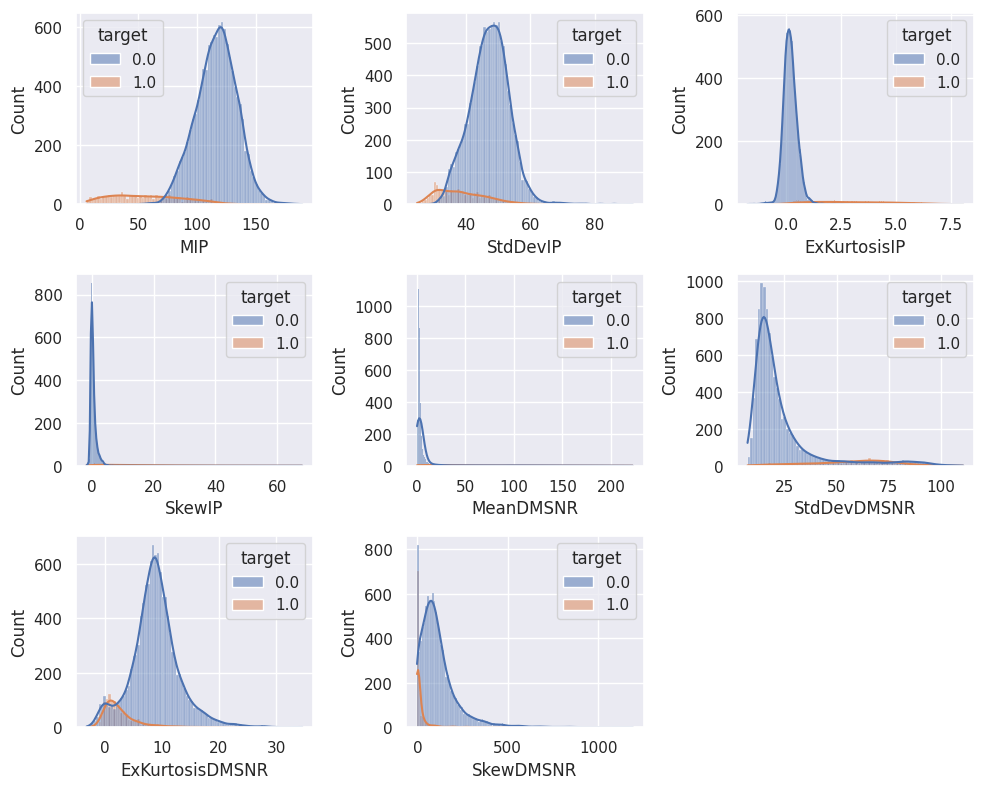

In [14]:
# 2.3 Lets look at the distribution plot of the features:
#     styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

sns.set_theme()
pos = 1
fig = plt.figure(figsize=(10,18));
for i in data.columns[:-1]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    _=sns.histplot(data = data, x = i,ax=ax, hue = 'target', kde = 'True');
    plt.tight_layout();

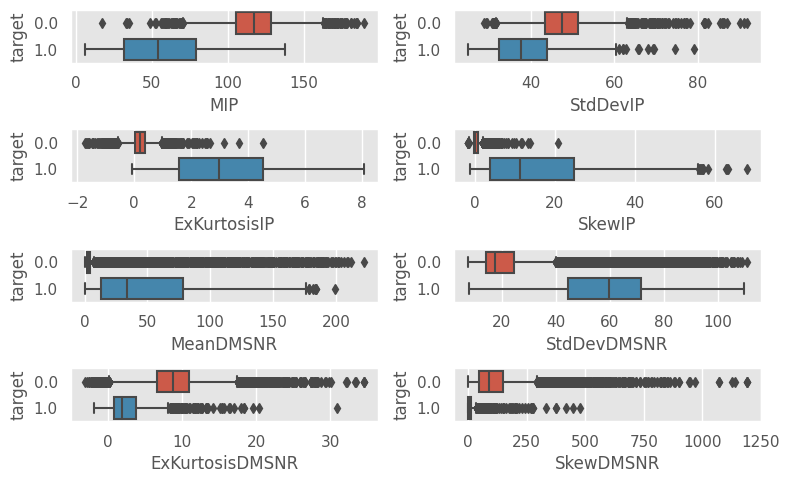

In [15]:
# 2.4 Lets look at how features are related to target:

plt.style.use("ggplot")
df = data.copy()
df['target'] = df['target'].astype("string")
plt.style.use("ggplot")
pos = 1
fig = plt.figure(figsize=(8,8));
for i in data.columns[:-1]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=sns.boxplot(data=df, x=i, y='target')
    plt.tight_layout();

del(df)

In [16]:
# 2.5 Pop out target and check
#       proportions of classes

y = data.pop("target")

# 2.0.2 Imbalanced data:
y.value_counts(normalize = True)

0.0    0.907966
1.0    0.092034
Name: target, dtype: float64

## Transform numeric data to categorical

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in `CatEncodersFamily` class.

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in `orig_train` and `train_binned` on the one hand and `orig_test` and `test_binned` on the other hand.

In [17]:
# 3.0 How many unique values exist per column?
#     So 30 bins per column should not be excessive:

for i in data.columns[:-1]:
  print(f"No of unique values in {i}:  \t {data[i].nunique()}")

No of unique values in MIP:  	 7192
No of unique values in StdDevIP:  	 12510
No of unique values in ExKurtosisIP:  	 10793
No of unique values in SkewIP:  	 12528
No of unique values in MeanDMSNR:  	 7224
No of unique values in StdDevDMSNR:  	 11348
No of unique values in ExKurtosisDMSNR:  	 12526


In [18]:
# 3.0.1 Discretise all features of data. And also split dataset.
#     into train/test:

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data,
                                                                                 y,
                                                                                 bins = 30,
                                                                                 test_size = 0.1,
                                                                                 genColName = False  # Keep orig col names
                                                                                )

In [19]:
# 3.0.2 Check  original data:

orig_train.shape   # (11276, 9)
orig_train.head(3)
orig_test.head(3)
orig_test.shape   # (1252, 9)


(11276, 9)

MIP   StdDevIP  ExKurtosisIP    SkewIP  MeanDMSNR  StdDevDMSNR  \
279    78.460938  37.632246      0.761066  2.516426   2.241639    17.166000   
9802  137.500000  37.165172           NaN  1.245371   3.239130    25.127128   
8792  104.585938  48.763704      1.217617  1.745403  43.056856    68.276894   

      ExKurtosisDMSNR  SkewDMSNR  target  
279          8.768599  85.693532     0.0  
9802         8.179860  68.019792     0.0  
8792         1.392848   0.564216     0.0

MIP   StdDevIP  ExKurtosisIP    SkewIP  MeanDMSNR  StdDevDMSNR  \
437    121.156250  48.372971      0.375485 -0.013165   3.168896    18.399367   
10455   76.968750  36.175557      0.712898  3.388719   2.399666    17.570997   
7088   130.585938  53.229534      0.133408 -0.297242   2.743311    22.362553   

       ExKurtosisDMSNR   SkewDMSNR  target  
437           7.449874   65.159298     0.0  
10455         9.414652  102.722975     0.0  
7088          8.508364   74.031324     0.0

(1252, 9)

In [20]:
# 3.0.3 Check discretised features
#       train/test in binned data and original
#       split data have the same row-indicies:

train_binned.shape     # (11276, 9)
train_binned.head(3)
test_binned.head(3)
test_binned.shape      # (1252, 9)

(11276, 9)

MIP StdDevIP ExKurtosisIP SkewIP MeanDMSNR StdDevDMSNR ExKurtosisDMSNR  \
279   412       86          128    162       201         243            2810   
9802  422       86          NaN    162       201         246            2810   
8792  417      811         1210    162       206        2418             284   

     SkewDMSNR  target  
279        323     0.0  
9802       322     0.0  
8792       321     0.0

MIP StdDevIP ExKurtosisIP SkewIP MeanDMSNR StdDevDMSNR ExKurtosisDMSNR  \
437    419      811          127    161       201         244             289   
10455  412       86          128    163       201         243            2810   
7088   421      813          126    161       201         245            2810   

      SkewDMSNR  target  
437         322     0.0  
10455       323     0.0  
7088        322     0.0

(1252, 9)

In [21]:
# 3.0.4 No of unique values in train_binned
#       Less than 30 (no of bins) in a feature
#       would cause NaN values in test_binned
#       when transformed to numeric:

for i in train_binned.columns[:-1]:
  print(f"No of unique values in feature {i} are \t {train_binned[i].nunique()}")

No of unique values in feature MIP are 	 30
No of unique values in feature StdDevIP are 	 28
No of unique values in feature ExKurtosisIP are 	 30
No of unique values in feature SkewIP are 	 29
No of unique values in feature MeanDMSNR are 	 30
No of unique values in feature StdDevDMSNR are 	 30
No of unique values in feature ExKurtosisDMSNR are 	 30
No of unique values in feature SkewDMSNR are 	 28


### Impute data: Learn using train data:

In [22]:
# 4.1 Impute original data
#     strategy: 'median'

si = SimpleImputer(strategy = 'median')
orig_train[:] = si.fit_transform(orig_train)
orig_test[:] = si.transform(orig_test)

In [23]:
# 4.2 Impute binned data:
#     strategy: 'most_frequent'

si = SimpleImputer(strategy = 'most_frequent')
train_binned[:] = si.fit_transform(train_binned)
test_binned[:] = si.transform(test_binned)

In [24]:
# 4.3 Pop out targets:

ytr = train_binned.pop('target')
yte = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [25]:
## 5.0 Developing models
#      Decide our cat_cols

if 'target' not in train_binned.columns:
  cat_cols = list(train_binned.columns)  # All columns
  # Keep interacting columns, same
  # as cat columns:
  interactingCatCols = cat_cols  # alternative: []

len(cat_cols)  # 8



8

In [26]:
# 5.1 Instantiate CustomTransformer class:
ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,0,0],  # This is better than all 1s
                       saveGraph = True  # Save graph files also
                                         # By default saved to /<currentFolder>/allmodels/models/
                       )

# 5.1.1 Fit it on train data:
ct.fit(train_binned, cat_cols, interactingCatCols)


Folder  /content/allmodels/models created to deposit cat encoder models and graph related files
Record set no is 1  
Set of records is:  [('MIP', 'StdDevIP', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'ExKurtosisIP', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'SkewIP', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'MeanDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'StdDevDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'ExKurtosisDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'SkewDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'SkewIP_p_SkewDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'StdDevDMSNR_p_ExKurtosisDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'MIP_p_SkewDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'MIP_p_MeanDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'SkewIP_p_MeanDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'ExKurtosisIP_p_MeanDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'StdDevIP_p_MeanDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'MeanDMSNR_p_ExKurtosisDMSNR', [1, 1, 1, 1, None, 0, 0]), ('MIP', 'StdDevDMSNR_p_SkewDMSNR', [1, 1,

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 0, 0],
                  modelsPath=PosixPath('/content/allmodels/models'),
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'),
                  saveGraph=True)

### Save class instance

In [27]:
# Save class instance
utils.savePythonObject(ct, "transformer.pkl", dataPath)

Folder '/gdrive/MyDrive/Colab_data_files/pulsar/datafiles/' does not exist
Being created..
Object saved to: /gdrive/MyDrive/Colab_data_files/pulsar/datafiles/transformer.pkl


### Restore class instance

In [28]:
# Restore class instance
ct = utils.restorePythonObject("transformer.pkl", dataPath)

## Data transformation

In [29]:
# 6.0 Transform both 'test_binned' and 'train_binned' data:
#     Takes time....

test_trans = ct.transform(test_binned[cat_cols])

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  1120
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 8.784032 MB
Mem usage after dtype transformation is: 4.437088 MB


'Transformed test data shape: (1252, 876)'

In [30]:
# 6.0.1 Transform train_binned now:
#       Takes time....

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  1120
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 79.112416 MB
Mem usage after dtype transformation is: 39.962144 MB


'Transformed train data shape: (11276, 876)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [31]:
# 6.1 Observe data now:
#     It also has original binned cols (10):

train_trans.head()
test_trans.head()

MIP StdDevIP ExKurtosisIP SkewIP MeanDMSNR StdDevDMSNR ExKurtosisDMSNR  \
0  412       86          128    162       201         243            2810   
1  422       86          126    162       201         246            2810   
2  417      811         1210    162       206        2418             284   
3  421      812          126    161       201         245             289   
4  417       86          127    162       201         242            2811   

  SkewDMSNR  deg_MIP_ck_StdDevIP  eig_MIP_ck_StdDevIP  ...  \
0       323                  1.0             0.185046  ...   
1       322                  1.0             0.185046  ...   
2       321                  1.0             0.185046  ...   
3       322                  1.0             0.185046  ...   
4       324                  1.0             0.185046  ...   

   clu_SkewDMSNR_ck_MIP_p_SkewIP  deg_SkewDMSNR_ck_ExKurtosisIP_p_StdDevDMSNR  \
0                       0.880342                                     0.703704   
1                       0.880342                                     0.703704   
2                       0.880342                                     0.962963   
3                       0.880342                                     0.703704   
4                       0.880342                                     0.703704   

   eig_SkewDMSNR_ck_ExKurtosisIP_p_StdDevDMSNR  \
0                                     0.163211   
1                                     0.163211   
2                                     0.214329   
3                                     0.163211   
4                                     0.163211   

   pr_SkewDMSNR_ck_ExKurtosisIP_p_StdDevDMSNR  \
0                                    0.031360   
1                                    0.031360   
2                                    0.041111   
3                                    0.031360   
4                                    0.031360   

   clu_SkewDMSNR_ck_ExKurtosisIP_p_StdDevDMSNR  \
0                                     0.970760   
1                                     0.970760   
2                                     0.855385   
3                                     0.970760   
4                                     0.970760   

   eig_SkewDMSNR_ck_ExKurtosisIP_p_SkewDMSNR  \
0                                   0.026863   
1                                   0.128119   
2                                  -0.086952   
3                                   0.128119   
4                                   0.093507   

   deg_SkewDMSNR_ck_StdDevIP_p_ExKurtosisDMSNR  \
0                                     0.148148   
1                                     0.111111   
2                                     0.555556   
3                                     0.111111   
4                                     0.222222   

   eig_SkewDMSNR_ck_StdDevIP_p_ExKurtosisDMSNR  \
0                                     0.126599   
1                                     0.101972   
2                                     0.438515   
3                                     0.101972   
4                                     0.185351   

   pr_SkewDMSNR_ck_StdDevIP_p_ExKurtosisDMSNR  \
0                                    0.029756   
1                                    0.023699   
2                                    0.096081   
3                                    0.023699   
4                                    0.041183   

   clu_SkewDMSNR_ck_StdDevIP_p_ExKurtosisDMSNR  
0                                     0.833333  
1                                     1.000000  
2                                     0.314286  
3                                     1.000000  
4                                     0.666667  

[5 rows x 876 columns]

MIP StdDevIP ExKurtosisIP SkewIP MeanDMSNR StdDevDMSNR ExKurtosisDMSNR  \
0  419      811          127    161       201         244             289   
1  412       86          128    163       201         243            2810   
2  421      813          126    161       201         245            2810   
3  425      811          125    161       203         243             285   
4  413       86          128    163       201         244            2810   

  SkewDMSNR  deg_MIP_ck_StdDevIP  eig_MIP_ck_StdDevIP  ...  \
0       322                  1.0             0.185046  ...   
1       323                  1.0             0.185046  ...   
2       322                  1.0             0.185046  ...   
3       321                  1.0             0.185046  ...   
4       322                  1.0             0.185046  ...   

   clu_SkewDMSNR_ck_MIP_p_SkewIP  deg_SkewDMSNR_ck_ExKurtosisIP_p_StdDevDMSNR  \
0                       0.880342                                     0.703704   
1                       0.880342                                     0.703704   
2                       0.880342                                     0.703704   
3                       0.880342                                     0.962963   
4                       0.880342                                     0.703704   

   eig_SkewDMSNR_ck_ExKurtosisIP_p_StdDevDMSNR  \
0                                     0.163211   
1                                     0.163211   
2                                     0.163211   
3                                     0.214329   
4                                     0.163211   

   pr_SkewDMSNR_ck_ExKurtosisIP_p_StdDevDMSNR  \
0                                    0.031360   
1                                    0.031360   
2                                    0.031360   
3                                    0.041111   
4                                    0.031360   

   clu_SkewDMSNR_ck_ExKurtosisIP_p_StdDevDMSNR  \
0                                     0.970760   
1                                     0.970760   
2                                     0.970760   
3                                     0.855385   
4                                     0.970760   

   eig_SkewDMSNR_ck_ExKurtosisIP_p_SkewDMSNR  \
0                                   0.128119   
1                                   0.026863   
2                                   0.128119   
3                                  -0.086952   
4                                   0.128119   

   deg_SkewDMSNR_ck_StdDevIP_p_ExKurtosisDMSNR  \
0                                     0.111111   
1                                     0.148148   
2                                     0.111111   
3                                     0.555556   
4                                     0.111111   

   eig_SkewDMSNR_ck_StdDevIP_p_ExKurtosisDMSNR  \
0                                     0.101972   
1                                     0.126599   
2                                     0.101972   
3                                     0.438515   
4                                     0.101972   

   pr_SkewDMSNR_ck_StdDevIP_p_ExKurtosisDMSNR  \
0                                    0.023699   
1                                    0.029756   
2                                    0.023699   
3                                    0.096081   
4                                    0.023699   

   clu_SkewDMSNR_ck_StdDevIP_p_ExKurtosisDMSNR  
0                                     1.000000  
1                                     0.833333  
2                                     1.000000  
3                                     0.314286  
4                                     1.000000  

[5 rows x 876 columns]

## Make an archive of files in gdrive
This is for later use


In [32]:
# 6.2 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Archive of graph files to gdrive

In [33]:
# 6.2.1 Delete if a folder already exists on gdrive:
#outputfolder = Path("/gdrive/MyDrive/Colab_data_files/pulsar/")
#if outputfolder.exists() and outputfolder.is_dir():
#    shutil.rmtree(outputfolder)  # Delete if it exists

In [34]:
# 6.3 Archive folder where graph files are stored to gdrive
output_filename = Path(modelsPath)
dir_to_be_archived = "/content/allmodels/models/"
shutil.make_archive(output_filename, 'zip', dir_to_be_archived )


# 6.3.2 Unpack the zipped file at gdrive now:
shutil.unpack_archive(str(output_filename) +".zip", output_filename, 'zip')

'/gdrive/MyDrive/Colab_data_files/pulsar/models.zip'

In [35]:
# 6.4 Let us have a look at our list of (graph) stored files:
p = Path(modelsPath).glob('**/*')
files = [x for x in p if x.is_file()]
files[:3]

[PosixPath('/gdrive/MyDrive/Colab_data_files/pulsar/models/ExKurtosisDMSNR_bigraph_MeanDMSNR_p_StdDevDMSNR.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/pulsar/models/SkewDMSNR_projected_SkewIP_p_StdDevDMSNR.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/pulsar/models/ExKurtosisDMSNR_projected_SkewIP.gml')]

### Archive of datafiles

In [36]:
# 6.5  Let us also copy our original and binned
#      files to a local folder
#       We will later copy them to gfrive:


train_binned['target'] = ytr
test_binned['target'] = yte

destination = Path("/content/datafiles/data/")
destination.mkdir(parents=True, exist_ok=True)

trfile = destination / "train_binned.pkl"
tefile = destination / "test_binned.pkl"
ortrfile = destination / "orig_train.pkl"
ortefile = destination / "orig_test.pkl"
tr_trans = destination / "train_trans.pkl"
te_trans = destination / "test_trans.pkl"

train_binned.to_pickle(trfile)
test_binned.to_pickle(tefile)
orig_train.to_pickle(ortrfile)
orig_test.to_pickle(ortefile)
train_trans.to_pickle(tr_trans)
test_trans.to_pickle(te_trans)

In [37]:
# 6.5.1 Delete if a folder already exists on gdrive:
#outputfolder = Path(dataPath)
#if outputfolder.exists() and outputfolder.is_dir():
#    shutil.rmtree(outputfolder)  # Delete if it exists

In [38]:
# 6.5.2 Archive folder where pickle files are stored to gdrive
output_filename = Path(dataPath)
dir_to_be_archived = "/content/datafiles/data/"
shutil.make_archive(output_filename, 'zip', dir_to_be_archived )



# 6.6 Unpack the zipped file now:
shutil.unpack_archive(str(output_filename)+".zip", output_filename, 'zip')

'/gdrive/MyDrive/Colab_data_files/pulsar/datafiles.zip'

In [39]:
# 6.7 Let us have a look at our list of pickled files:
p = Path(dataPath).glob('**/*')
files = [x for x in p if x.is_file()]
files

[PosixPath('/gdrive/MyDrive/Colab_data_files/pulsar/datafiles/transformer.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/pulsar/datafiles/orig_train.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/pulsar/datafiles/orig_test.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/pulsar/datafiles/train_trans.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/pulsar/datafiles/train_binned.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/pulsar/datafiles/test_binned.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/pulsar/datafiles/test_trans.pkl')]

In [40]:
# 6.8 Pop out target:
#     It is already popped out

#_= orig_train.pop('target')
#_= orig_test.pop('target')

## PCAs with original data and with transformed data:
We perform PCA of transformed data with all features. We latter perform PCA again but only with important features.

In [41]:
# 7.0
'target' in list(orig_train.columns)   # True
'target' in list(train_trans.columns)  # False

True

False

In [42]:
# 7.0.1 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape  # (11276, 2)

(11276, 2)

In [43]:
# 7.1 PCA with transformed train data.
#     Drop all cat_cols first:

trans_pca = train_trans.iloc[:,len(cat_cols):]   # Drop the six binned columns
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape  # (11276, 2)

(11276, 2)

In [44]:
# 7.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

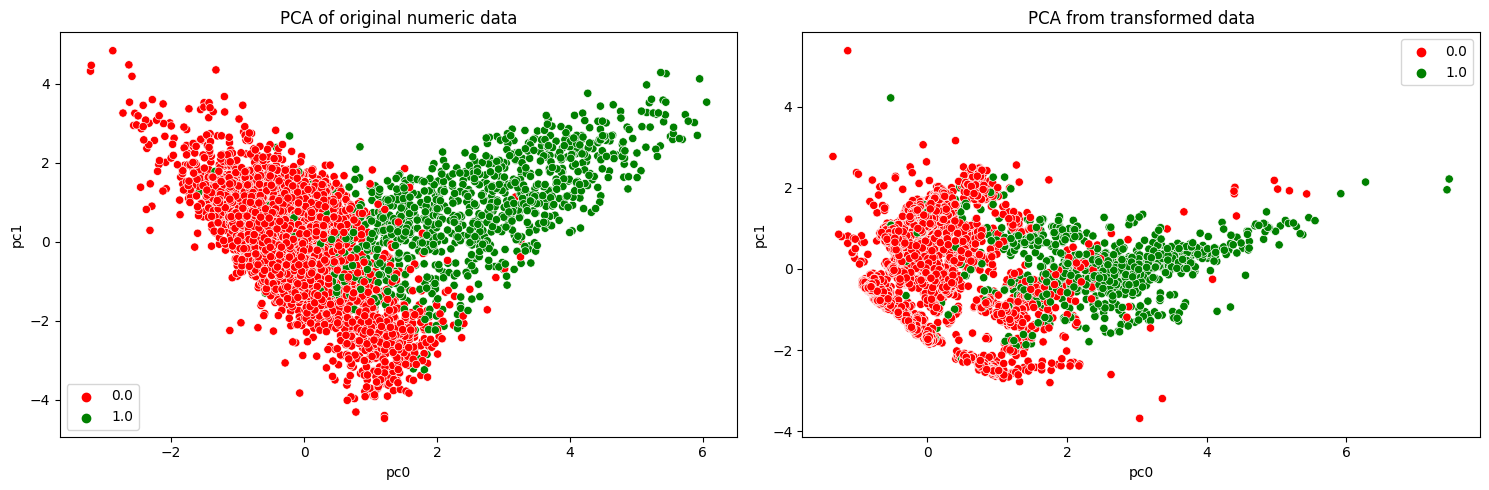

In [45]:
# 8.0 2D PCA plot from original train data:

plt.style.use("default")
fig = plt.figure(figsize = (15,5));
fig.add_subplot(1,2,1);
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA of original numeric data');

# 8.1 2D PCA plot from transformed train data:

fig.add_subplot(1,2,2);
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA from transformed data') ;

plt.tight_layout();

##xgboost modeling of original features and of transformed features


In [46]:
# 9.0 Original train/test data:

model_orig = xgb.XGBClassifier( n_estimators= 700,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 6,
                               subsample = 0.8,
                               random_state = None,
                              )

# 9.0.1
tr_X =   orig_train.iloc[:,:-1]  # Exclude target
test_X = orig_test.iloc[:,:-1]
ytr = ytr
yte = yte

# 9.0.2
model_orig.fit(tr_X, ytr.values,
               early_stopping_rounds = 100,
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
               eval_metric = ['auc']
              )

[14:00:32] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[14:00:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.95023	validation_1-auc:0.94589
[14:00:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.97006	validation_1-auc:0.96251
[14:00:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.96945	validation_1-auc:0.96002
[14:00:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.96979	validation_1-auc:0.95983
[14:00:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.96904	validation_1-auc:0.95925
[14:00:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_d

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [47]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"  # 0.975222133
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"  # 216

'Best auc from orig train/test data: 0.9752221339305064'

'Best iteration from orig train/test data: 216'

In [48]:
# 9.2 Modeling with transformed train/test data:

model_trans = xgb.XGBClassifier( n_estimators= 200,
                                  verbosity = 3,
                                  eta = 0.06,
                                  max_depth = 14,
                                  subsample = 0.8,
                                  random_state = None,
                           )

# 9.2.1
tr_X =   train_trans.iloc[:,len(cat_cols):]
test_X = test_trans.iloc[:,len(cat_cols):]
ytr = ytr
yte = yte

# 9.2.2
model_trans.fit(tr_X, ytr.values,
          early_stopping_rounds = 100,
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']
          )



[14:00:48] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[14:00:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=12
[0]	validation_0-auc:0.94827	validation_1-auc:0.94577
[14:00:50] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.96598	validation_1-auc:0.94549
[14:00:50] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation_0-auc:0.97324	validation_1-auc:0.96086
[14:00:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.97373	validation_1-auc:0.96044
[14:00:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=11
[4]	validation_0-auc:0.97572	validation_1-auc:0.95966
[14:00:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned node

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

### Learning curve plots

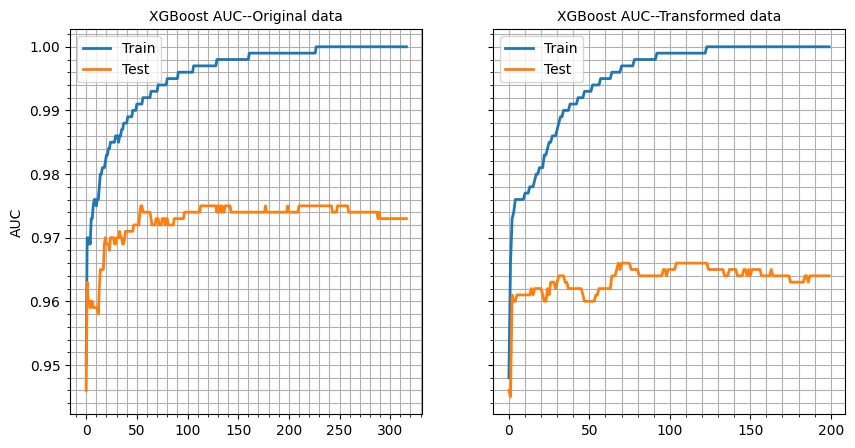

In [49]:
# 9.3 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = True);

results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
ax[0].legend();
ax[0].grid(visible = True, which = 'both')
ax[0].minorticks_on()
ax[0].set_ylabel('AUC');
ax[0].set_title("XGBoost AUC--Original data", fontsize = 10)

# 9.4 Modeling with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],3), linewidth=2, label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth = 2, label='Test');
ax[1].legend();
ax[1].grid(visible = True, which = 'both')
ax[1].minorticks_on()
ax[1].set_title('XGBoost AUC--Transformed data', fontsize = 10);
plt.show();

In [50]:
# 9.5
f"Best auc from transformed train/test data: {model_trans.best_score}"  # 0.96482779/0.9665775722
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"  # 86/65

'Best auc from transformed train/test data: 0.966457174504563'

'Best iteration from transformed train/test data: 106'

## Feature importance of transformed features:
Extract feature importance using function `utils.xgImptFeatures()`. The function outputs three objects as follows::
>`fe_1`: List of columns arranged in order of descending xgboost impt(feat-impt >0)<br>
>`fe_0`: List of columns whose xgboost importance is zero<br>
>`fe`: One-column dataframe of feature importance(top-down). Col name is 'imp'<br>

In [51]:
# 10.0 Get feature importance:

fe_1, fe_0, fe = utils.xgImptFeatures(model_trans,  train_trans.iloc[:,len(cat_cols):].columns)
print("\n=== DataFrame  of impt features top-down =======\n")
fe.iloc[:5]
print("\n\n== Column-list whose feat impt >0 =======\n")
fe_1[:5]     # Arranged in descending order of impt
print("\n\n===Column-list whose feat impt is 0 =======\n")
fe_0[:5]


Order of feature importance is by 'gain'

=== DataFrame  of impt features top-down =======



imp
clu_SkewIP_ck_StdDevIP_p_MeanDMSNR              0.304151
eig_SkewIP_ck_MIP_p_StdDevIP                    0.235542
pr_ExKurtosisIP_ck_MeanDMSNR_p_StdDevDMSNR      0.022571
eig_ExKurtosisIP_ck_ExKurtosisIP_p_StdDevDMSNR  0.020494
eig_SkewDMSNR_ck_MIP_p_StdDevDMSNR              0.005717



== Column-list whose feat impt >0 =======



['clu_SkewIP_ck_StdDevIP_p_MeanDMSNR',
 'eig_SkewIP_ck_MIP_p_StdDevIP',
 'pr_ExKurtosisIP_ck_MeanDMSNR_p_StdDevDMSNR',
 'eig_ExKurtosisIP_ck_ExKurtosisIP_p_StdDevDMSNR',
 'eig_SkewDMSNR_ck_MIP_p_StdDevDMSNR']



===Column-list whose feat impt is 0 =======



['pr_StdDevIP_ck_SkewIP_p_SkewDMSNR',
 'eig_StdDevIP_ck_StdDevDMSNR',
 'eig_StdDevDMSNR_ck_ExKurtosisIP_p_SkewDMSNR',
 'clu_StdDevIP_ck_StdDevDMSNR',
 'clu_MeanDMSNR_ck_MIP_p_SkewIP']

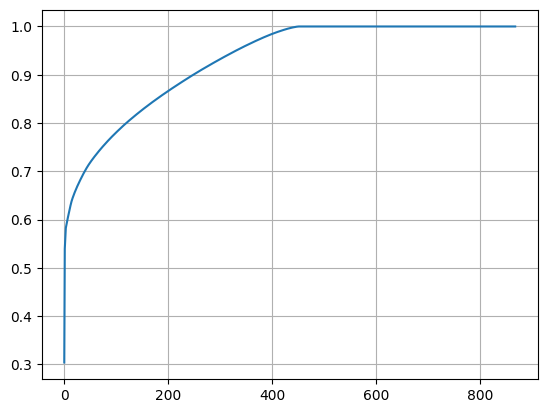

In [52]:
# 10.1 Cumulative sum of feature importance.
#      Last many columns have zero or (near zero)
#      importance:

plt.plot(range(len(fe)), fe['imp'].cumsum().values);
plt.grid();

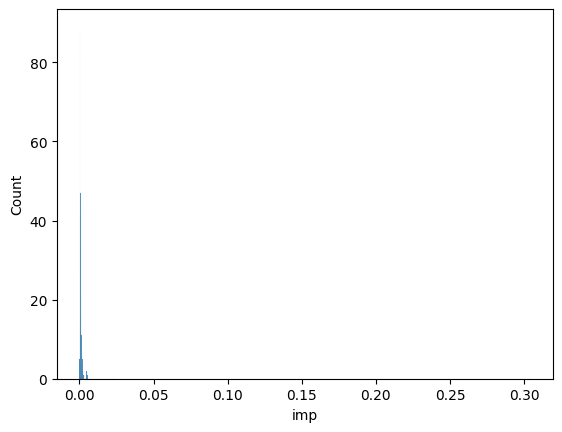

In [53]:
# 10.2 A histogram plot of feature importance score
#      Most columns have feature impt much below 0.01

sns.histplot(fe['imp'][fe_1]);

### XGBoost modeling with impt features

In [54]:
# 11.0 Modeling of transformed train/test data with impt features:

model_trans_impt = xgb.XGBClassifier( n_estimators= 200,
                                      verbosity = 3,
                                      eta = 0.06,
                                      max_depth = 14,
                                      subsample = 0.8,
                                      random_state = None,
                           )

# 11.0.1
tr_X =   train_trans[fe_1[:80]]
test_X = test_trans[fe_1[:80]]
ytr = ytr
yte = yte


# 11.0.2
model_trans_impt.fit(tr_X, ytr.values,
                    early_stopping_rounds = 50,
                    eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                    eval_metric = ['auc']
          )



[14:03:55] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[14:03:55] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=9
[0]	validation_0-auc:0.95067	validation_1-auc:0.94443
[14:03:55] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.96862	validation_1-auc:0.96285
[14:03:56] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.97153	validation_1-auc:0.96099
[14:03:56] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.97164	validation_1-auc:0.96092
[14:03:56] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=10
[4]	validation_0-auc:0.97313	validation_1-auc:0.96051
[14:03:56] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

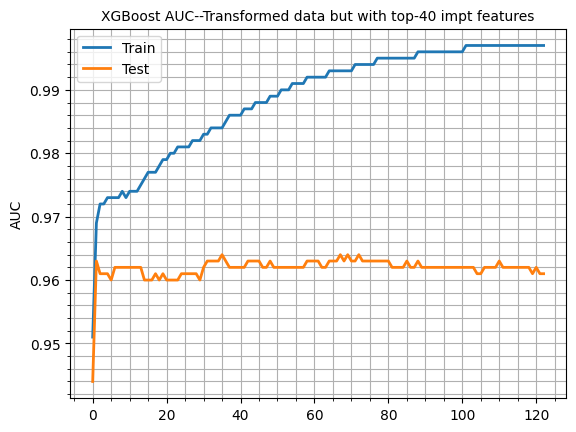

In [55]:
# 11.1 Learning curve: Modeling with transformed data:
#      We get results better than with all features:

results = model_trans_impt.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, np.round(results['validation_0']['auc'],3), linewidth = 2, label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth = 2, label='Test');
ax.legend();
ax.grid(visible = True, which = 'both')
ax.minorticks_on()
plt.ylabel('AUC');
plt.title('XGBoost AUC--Transformed data but with top-40 impt features', fontsize = 10);
plt.show();

## PCAs with impt features of transformed data:
While performing PCA, we only use impt features

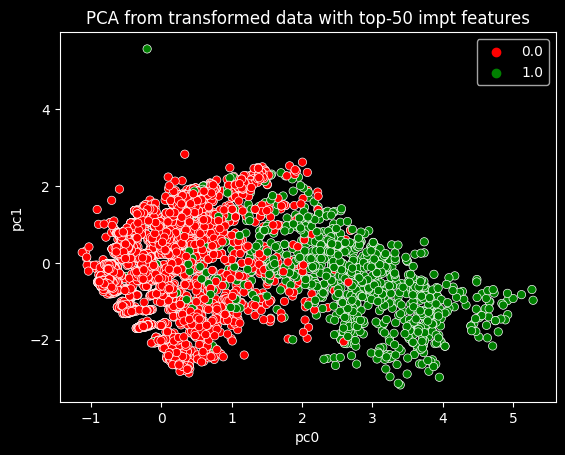

In [56]:
# 12.1 PCA with transformed train data.
#      We keep just the impt features

trans_pca = train_trans[fe_1[:50]] #.iloc[:,len(cat_cols):]
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

# 12.2 PCA plot from transformed data but with impt features:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed data with top-50 impt features') ;


## Correlation with orig columns
Correlation of extracted features with original features

In [57]:
# 13.0 Take top five imp features:

tt = train_trans[fe_1[:10]].copy()
tt.shape  # (9000,341)

(11276, 10)

In [58]:
# 13.1 Reindex orig_train and merge with 'tt':

ot= orig_train.reset_index(drop = True).copy()
result = ot.merge(tt, left_index = True, right_index=True )


Correlation heatmap shows good amount of correlation between the two sets of features

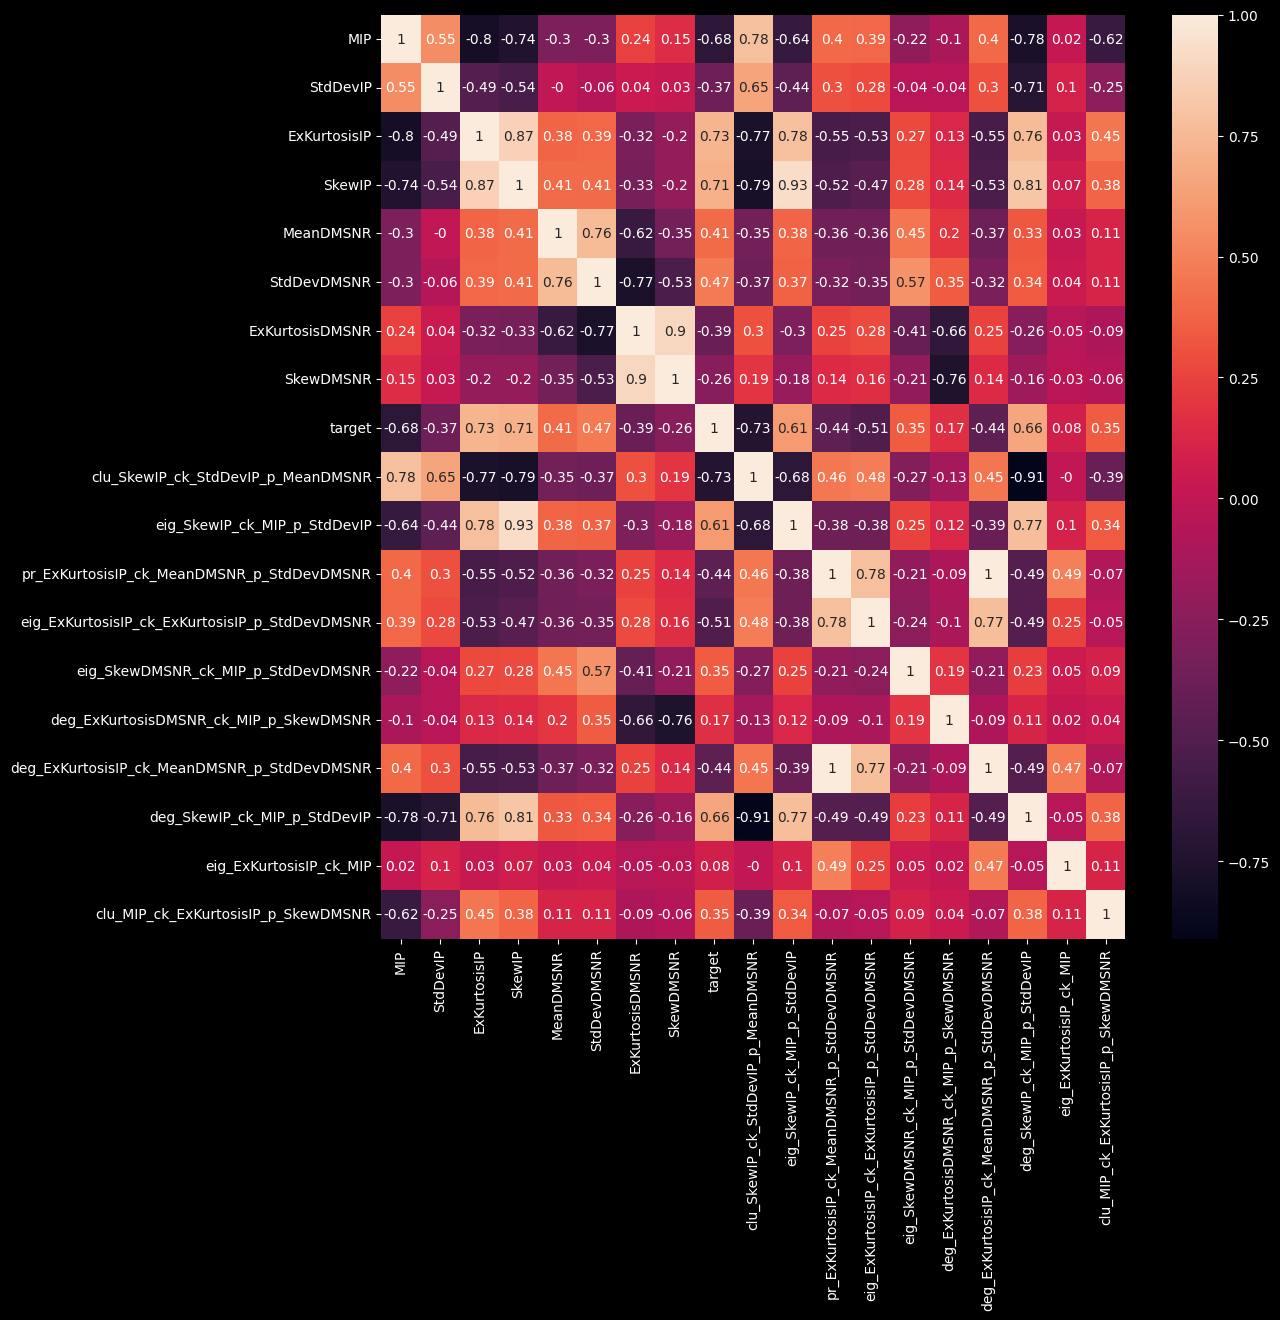

In [59]:
# 13.2 Correlation heatmap:

plt.figure(figsize = (12,12))
sns.heatmap(np.round(result.corr(),2), annot = True);

## Distribution of columns
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

eigenvector          0.322581
degree               0.225806
pagerank             0.225806
clusteringcoeff      0.225806
betweenness          0.000000
avgembeddedness      0.000000
leidencomsdensity    0.000000
dtype: float64

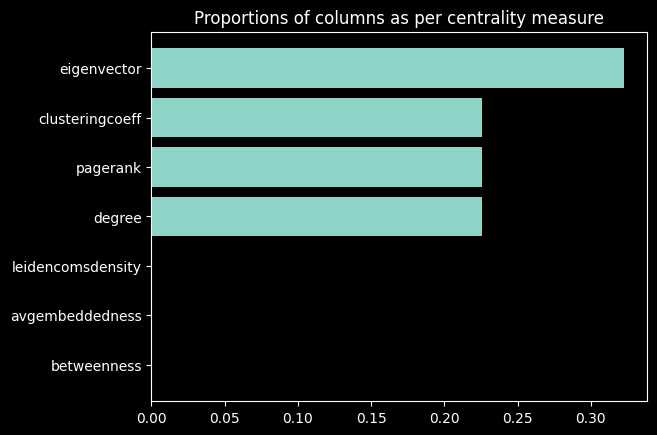

In [60]:
# 14.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
f
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [61]:
# 14.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 452'

'Columns whose impt is 0: 416'

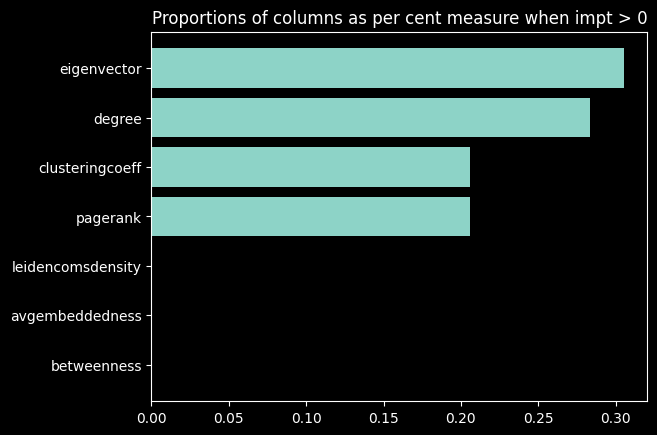

In [62]:
# 14.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [63]:
# 15.0 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [64]:
# 15.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 15.2 Score of all impt columns:
score[:5]

clu_SkewIP_ck_StdDevIP_p_MeanDMSNR                0.304151
eig_SkewIP_ck_MIP_p_StdDevIP                      0.235542
pr_ExKurtosisIP_ck_MeanDMSNR_p_StdDevDMSNR        0.022571
eig_ExKurtosisIP_ck_ExKurtosisIP_p_StdDevDMSNR    0.020494
eig_SkewDMSNR_ck_MIP_p_StdDevDMSNR                0.005717
Name: imp, dtype: float32

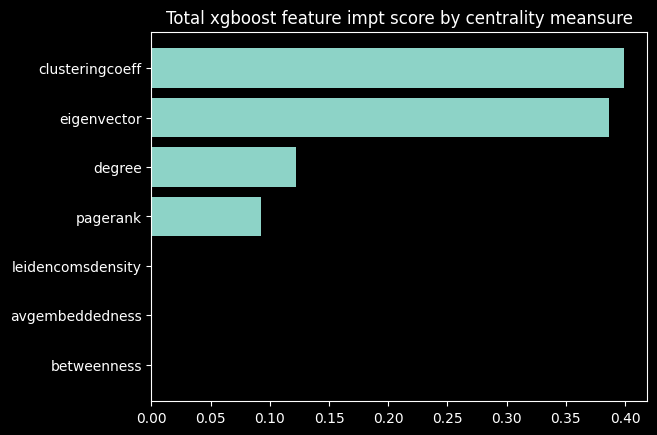

In [65]:
# 15.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Analysing Graphs

### Read graph files from gdrive

In [66]:
# 16.0 Mount gdrive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [67]:
# 16.1 Path where .gml files are placed:

pathToFolder = Path(modelsPath)
filelist = sorted(list(Path(modelsPath).iterdir()))
filelist[:5]   # a_bigraph_*

[PosixPath('/gdrive/MyDrive/Colab_data_files/pulsar/models/ExKurtosisDMSNR_bigraph_ExKurtosisDMSNR_p_SkewDMSNR.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/pulsar/models/ExKurtosisDMSNR_bigraph_ExKurtosisIP.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/pulsar/models/ExKurtosisDMSNR_bigraph_ExKurtosisIP_p_ExKurtosisDMSNR.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/pulsar/models/ExKurtosisDMSNR_bigraph_ExKurtosisIP_p_MeanDMSNR.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/pulsar/models/ExKurtosisDMSNR_bigraph_ExKurtosisIP_p_SkewDMSNR.gml')]

### Read data files from gdrive:

In [68]:
# 16.2
dataPath = Path(dataPath)
orig_test = pd.read_pickle(dataPath / "orig_test.pkl")
orig_train = pd.read_pickle(dataPath / "orig_train.pkl")
train_binned = pd.read_pickle(dataPath / "train_binned.pkl")
test_binned = pd.read_pickle(dataPath / "test_binned.pkl")
train_trans = pd.read_pickle(dataPath / "train_trans.pkl")
test_trans = pd.read_pickle(dataPath / "test_trans.pkl")
cat_cols = ['MIP', 'StdDevIP', 'ExKurtosisIP', 'SkewIP', 'MeanDMSNR', 'StdDevDMSNR', 'ExKurtosisDMSNR', 'SkewDMSNR']

In [69]:
# 16.3 check data files:
#      All have 'target' col
orig_train.head(2)   # has 'target'
orig_test.head(2)    # has 'target'
train_binned.head(2) # has 'target'
test_binned.head(2)  # has 'target'
train_trans.head(2)
test_trans.head(2)

MIP   StdDevIP  ExKurtosisIP    SkewIP  MeanDMSNR  StdDevDMSNR  \
279    78.460938  37.632246      0.761066  2.516426   2.241639    17.166000   
9802  137.500000  37.165172      0.224732  1.245371   3.239130    25.127128   

      ExKurtosisDMSNR  SkewDMSNR  target  
279          8.768599  85.693532     0.0  
9802         8.179860  68.019792     0.0

MIP   StdDevIP  ExKurtosisIP    SkewIP  MeanDMSNR  StdDevDMSNR  \
437    121.15625  48.372971      0.375485 -0.013165   3.168896    18.399367   
10455   76.96875  36.175557      0.712898  3.388719   2.399666    17.570997   

       ExKurtosisDMSNR   SkewDMSNR  target  
437           7.449874   65.159298     0.0  
10455         9.414652  102.722975     0.0

MIP StdDevIP ExKurtosisIP SkewIP MeanDMSNR StdDevDMSNR ExKurtosisDMSNR  \
279   412       86          128    162       201         243            2810   
9802  422       86          126    162       201         246            2810   

     SkewDMSNR  target  
279        323     0.0  
9802       322     0.0

MIP StdDevIP ExKurtosisIP SkewIP MeanDMSNR StdDevDMSNR ExKurtosisDMSNR  \
437    419      811          127    161       201         244             289   
10455  412       86          128    163       201         243            2810   

      SkewDMSNR  target  
437         322     0.0  
10455       323     0.0

MIP StdDevIP ExKurtosisIP SkewIP MeanDMSNR StdDevDMSNR ExKurtosisDMSNR  \
0  412       86          128    162       201         243            2810   
1  422       86          126    162       201         246            2810   

  SkewDMSNR  deg_MIP_ck_StdDevIP  eig_MIP_ck_StdDevIP  ...  \
0       323                  1.0             0.185046  ...   
1       322                  1.0             0.185046  ...   

   clu_SkewDMSNR_ck_MIP_p_SkewIP  deg_SkewDMSNR_ck_ExKurtosisIP_p_StdDevDMSNR  \
0                       0.880342                                     0.703704   
1                       0.880342                                     0.703704   

   eig_SkewDMSNR_ck_ExKurtosisIP_p_StdDevDMSNR  \
0                                     0.163211   
1                                     0.163211   

   pr_SkewDMSNR_ck_ExKurtosisIP_p_StdDevDMSNR  \
0                                     0.03136   
1                                     0.03136   

   clu_SkewDMSNR_ck_ExKurtosisIP_p_StdDevDMSNR  \
0                                      0.97076   
1                                      0.97076   

   eig_SkewDMSNR_ck_ExKurtosisIP_p_SkewDMSNR  \
0                                   0.026863   
1                                   0.128119   

   deg_SkewDMSNR_ck_StdDevIP_p_ExKurtosisDMSNR  \
0                                     0.148148   
1                                     0.111111   

   eig_SkewDMSNR_ck_StdDevIP_p_ExKurtosisDMSNR  \
0                                     0.126599   
1                                     0.101972   

   pr_SkewDMSNR_ck_StdDevIP_p_ExKurtosisDMSNR  \
0                                    0.029756   
1                                    0.023699   

   clu_SkewDMSNR_ck_StdDevIP_p_ExKurtosisDMSNR  
0                                     0.833333  
1                                     1.000000  

[2 rows x 876 columns]

MIP StdDevIP ExKurtosisIP SkewIP MeanDMSNR StdDevDMSNR ExKurtosisDMSNR  \
0  419      811          127    161       201         244             289   
1  412       86          128    163       201         243            2810   

  SkewDMSNR  deg_MIP_ck_StdDevIP  eig_MIP_ck_StdDevIP  ...  \
0       322                  1.0             0.185046  ...   
1       323                  1.0             0.185046  ...   

   clu_SkewDMSNR_ck_MIP_p_SkewIP  deg_SkewDMSNR_ck_ExKurtosisIP_p_StdDevDMSNR  \
0                       0.880342                                     0.703704   
1                       0.880342                                     0.703704   

   eig_SkewDMSNR_ck_ExKurtosisIP_p_StdDevDMSNR  \
0                                     0.163211   
1                                     0.163211   

   pr_SkewDMSNR_ck_ExKurtosisIP_p_StdDevDMSNR  \
0                                     0.03136   
1                                     0.03136   

   clu_SkewDMSNR_ck_ExKurtosisIP_p_StdDevDMSNR  \
0                                      0.97076   
1                                      0.97076   

   eig_SkewDMSNR_ck_ExKurtosisIP_p_SkewDMSNR  \
0                                   0.128119   
1                                   0.026863   

   deg_SkewDMSNR_ck_StdDevIP_p_ExKurtosisDMSNR  \
0                                     0.111111   
1                                     0.148148   

   eig_SkewDMSNR_ck_StdDevIP_p_ExKurtosisDMSNR  \
0                                     0.101972   
1                                     0.126599   

   pr_SkewDMSNR_ck_StdDevIP_p_ExKurtosisDMSNR  \
0                                    0.023699   
1                                    0.029756   

   clu_SkewDMSNR_ck_StdDevIP_p_ExKurtosisDMSNR  
0                                     1.000000  
1                                     0.833333  

[2 rows x 876 columns]

### Display graphs--Bigraphs and Projected

In [70]:
# 17.0 Get sample list of projected and bigraphs:

projected = [str(i).split("/")[-1] for i in filelist if 'MIP_projected' in str(i)]

bigraphs = [str(i).split("/")[-1] for i in filelist if 'MIP_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:8]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:8]    # projected graph files

['MIP_bigraph_SkewIP.gml',
 'MIP_bigraph_StdDevIP.gml',
 'MIP_bigraph_MeanDMSNR.gml',
 'MIP_bigraph_SkewDMSNR.gml',
 'MIP_bigraph_StdDevDMSNR.gml',
 'MIP_bigraph_ExKurtosisIP.gml',
 'MIP_bigraph_MIP_p_SkewIP.gml',
 'MIP_bigraph_MIP_p_StdDevIP.gml']



====



['MIP_projected_SkewIP.gml',
 'MIP_projected_StdDevIP.gml',
 'MIP_projected_MeanDMSNR.gml',
 'MIP_projected_SkewDMSNR.gml',
 'MIP_projected_StdDevDMSNR.gml',
 'MIP_projected_ExKurtosisIP.gml',
 'MIP_projected_MIP_p_SkewIP.gml',
 'MIP_projected_MIP_p_StdDevIP.gml']

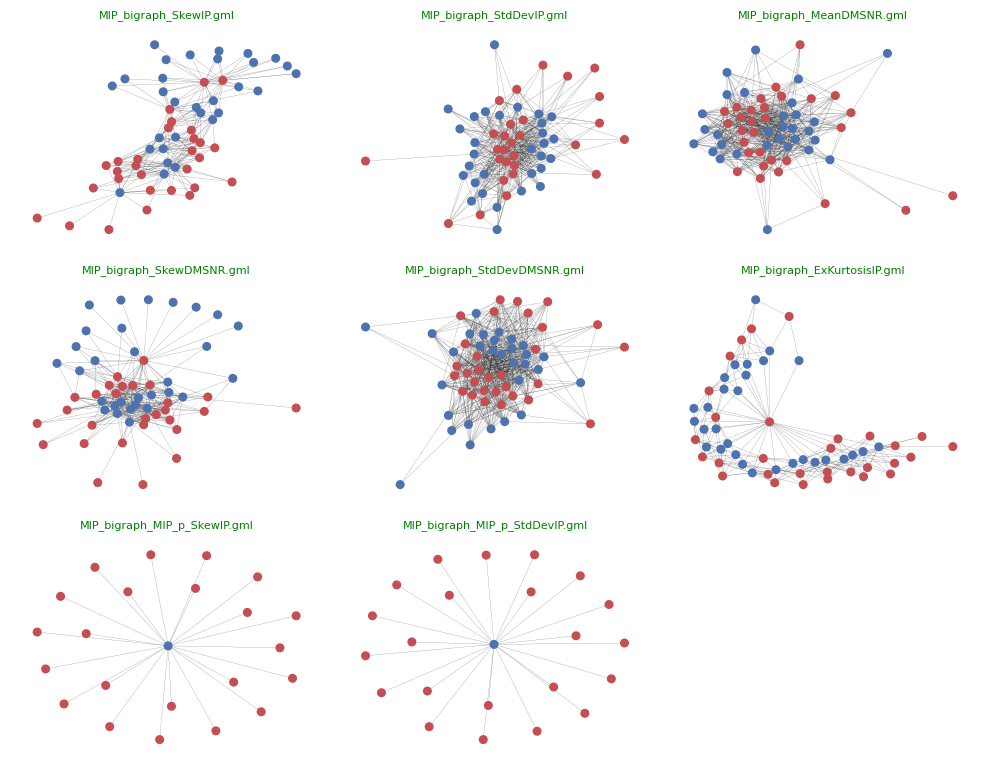

In [71]:
# 17.1 Plot of sample bigraphs:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:8]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _=utils.plotBipartiteGraph(bi,pathToFolder, ax = ax, title = bi, connected = True);
    plt.tight_layout();

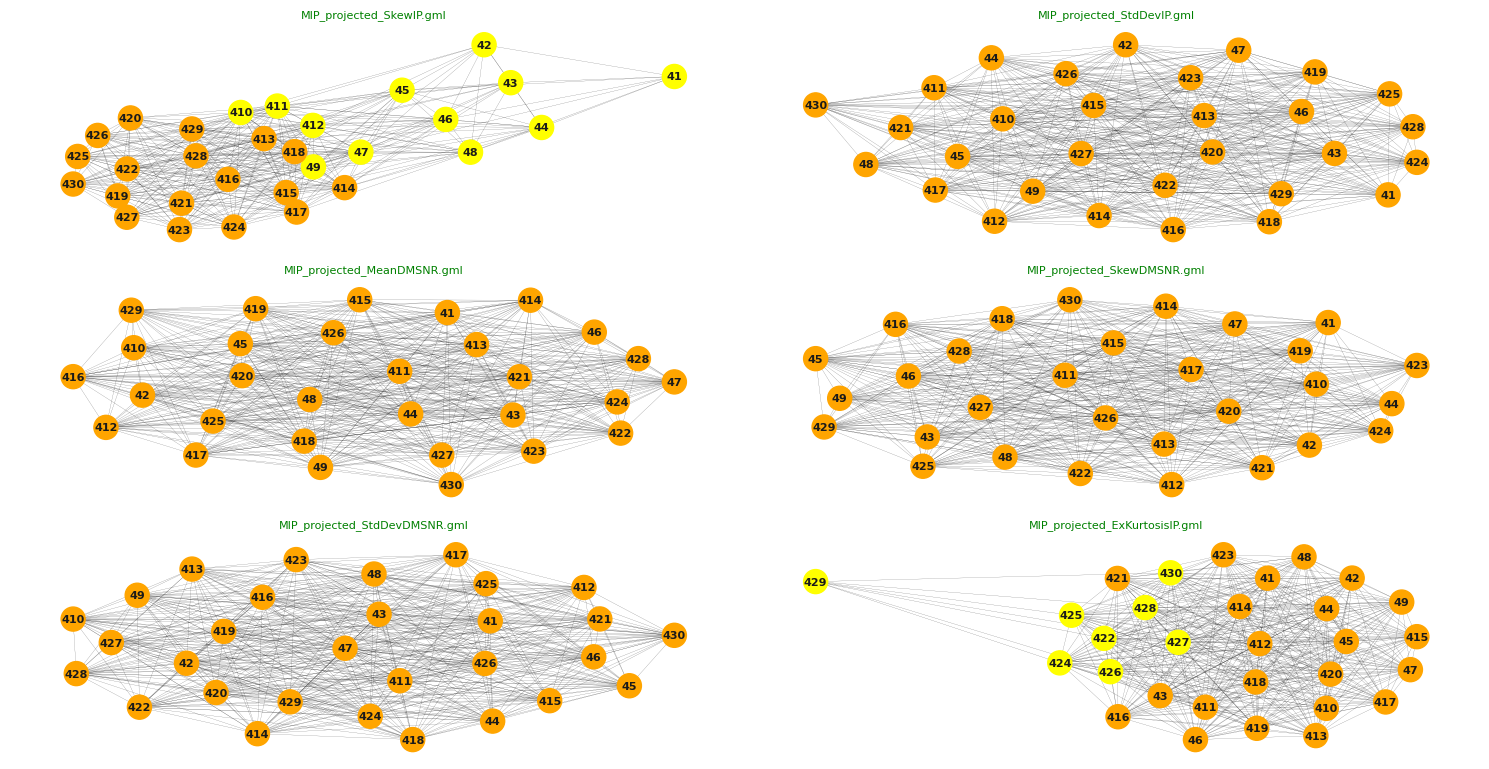

In [72]:
# 17.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:6]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,pathToFolder,ax = ax, withLabels = True, title = prj);
    plt.tight_layout();

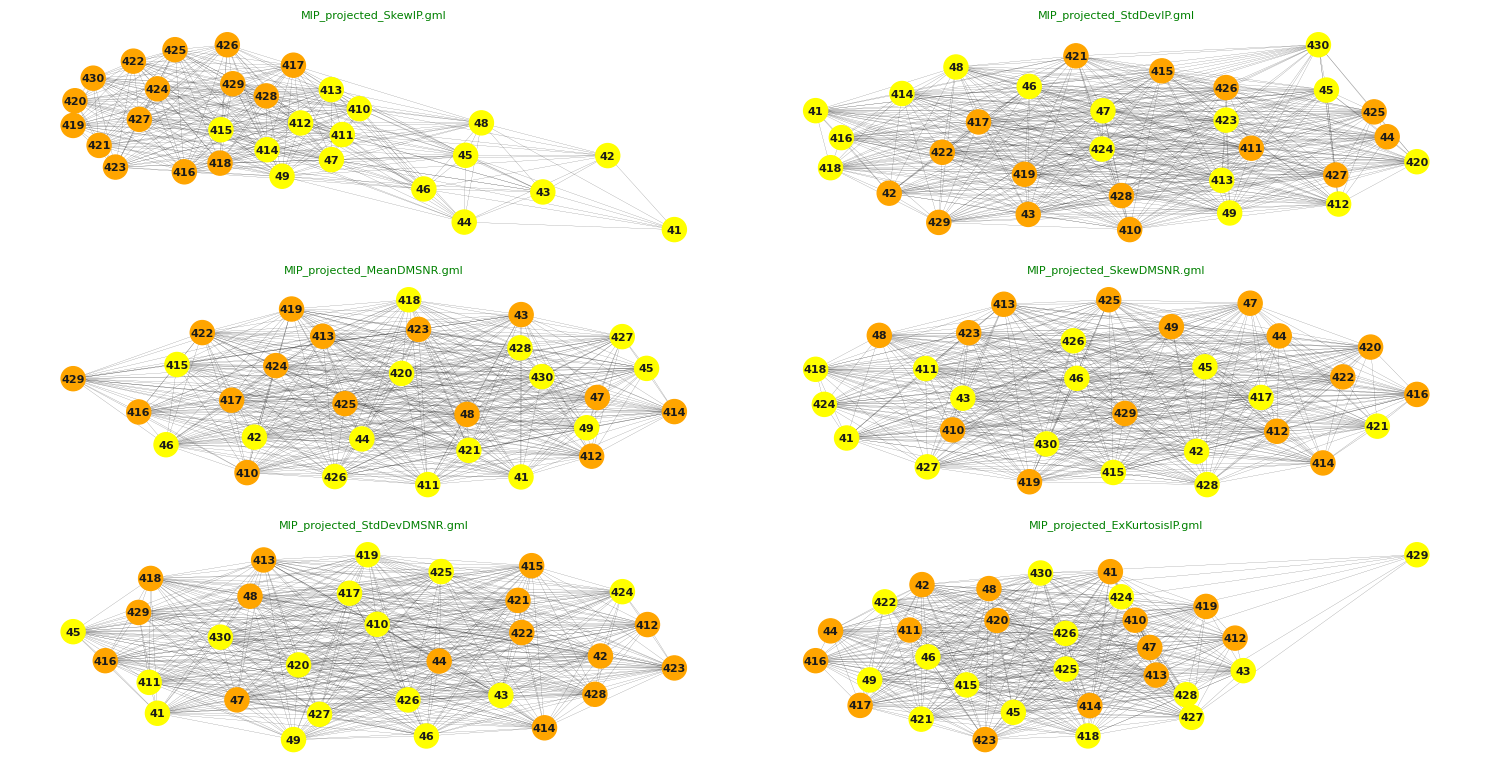

In [73]:
# 17.2.1 Community visualization using
#        kernighan_lin_bisection algo:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:6]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,pathToFolder,algo = nx.community.kernighan_lin_bisection, ax = ax, withLabels = True, title = prj);
    plt.tight_layout();

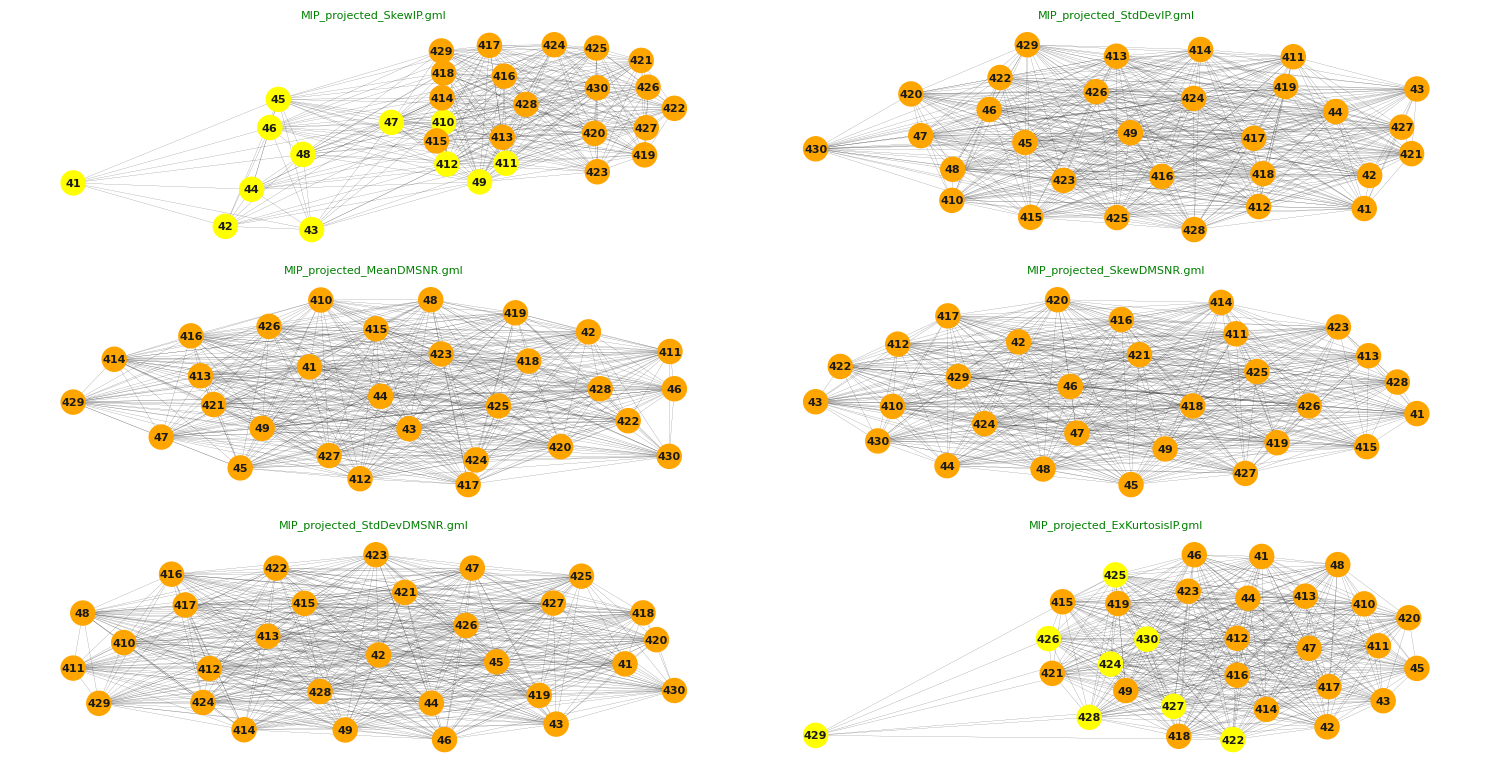

In [74]:
# 17.2.2 Community visualization using
#        louvain_communities algo:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:6]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,pathToFolder,algo = nx.community.louvain_communities, ax = ax, withLabels = True, title = prj);
    plt.tight_layout();

## Transform binned data to communities:

In [75]:
# 18.0 Transform each column bin as per the community
#       to which it belongs:

# 18.1 Binned cols are:
columnNames = train_binned.columns[:-1] # exclude target

# 18.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 18.3 Graph files are within:
#pathToGraphFolder= "/gdrive/MyDrive/Colab_data_files/allmodels/models"

# 18.4 Perform transformation of both train_binned and test_binend:
# 18.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []

# 18.4.2 PErform transformation to community structure
for algo in algolist:
  _,df_tr = utils.transformBinnedDF2Communities(columnNames,modelsPath,train_binned, algo = algo)
  _,df_te = utils.transformBinnedDF2Communities(columnNames,modelsPath,test_binned, algo = algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)

Reading file:  MIP_projected_StdDevIP.gml
Reading file:  MIP_projected_ExKurtosisIP.gml
Reading file:  MIP_projected_SkewIP.gml
Reading file:  MIP_projected_MeanDMSNR.gml
Reading file:  MIP_projected_StdDevDMSNR.gml
Reading file:  MIP_projected_ExKurtosisDMSNR.gml
Reading file:  MIP_projected_SkewDMSNR.gml
Reading file:  StdDevIP_projected_MIP.gml
Reading file:  StdDevIP_projected_ExKurtosisIP.gml
Reading file:  StdDevIP_projected_SkewIP.gml
Reading file:  StdDevIP_projected_MeanDMSNR.gml
Reading file:  StdDevIP_projected_StdDevDMSNR.gml
Reading file:  StdDevIP_projected_ExKurtosisDMSNR.gml
Reading file:  StdDevIP_projected_SkewDMSNR.gml
Reading file:  ExKurtosisIP_projected_MIP.gml
Reading file:  ExKurtosisIP_projected_StdDevIP.gml
Reading file:  ExKurtosisIP_projected_SkewIP.gml
Reading file:  ExKurtosisIP_projected_MeanDMSNR.gml
Reading file:  ExKurtosisIP_projected_StdDevDMSNR.gml
Reading file:  ExKurtosisIP_projected_ExKurtosisDMSNR.gml
Reading file:  ExKurtosisIP_projected_SkewDM

In [76]:
# 18.5 Observe few rows of transformed data:
fg_tr[0].shape   # (11276, 56)
fg_tr[0].head(5)
fg_te[0].head(5)


(11276, 56)

MIP_projected_StdDevIP.gml  MIP_projected_ExKurtosisIP.gml  \
279                            0                               0   
9802                           0                               1   
8792                           0                               0   
5631                           0                               0   
3168                           0                               0   

      MIP_projected_SkewIP.gml  MIP_projected_MeanDMSNR.gml  \
279                          1                            0   
9802                         0                            0   
8792                         0                            0   
5631                         0                            0   
3168                         0                            0   

      MIP_projected_StdDevDMSNR.gml  MIP_projected_ExKurtosisDMSNR.gml  \
279                               0                                  0   
9802                              0                                  0   
8792                              0                                  0   
5631                              0                                  0   
3168                              0                                  0   

      MIP_projected_SkewDMSNR.gml  StdDevIP_projected_MIP.gml  \
279                             0                           0   
9802                            0                           0   
8792                            0                           0   
5631                            0                           0   
3168                            0                           0   

      StdDevIP_projected_ExKurtosisIP.gml  StdDevIP_projected_SkewIP.gml  ...  \
279                                     0                              1  ...   
9802                                    0                              1  ...   
8792                                    0                              1  ...   
5631                                    0                              1  ...   
3168                                    0                              1  ...   

      ExKurtosisDMSNR_projected_MeanDMSNR.gml  \
279                                         0   
9802                                        0   
8792                                        1   
5631                                        0   
3168                                        0   

      ExKurtosisDMSNR_projected_StdDevDMSNR.gml  \
279                                           1   
9802                                          1   
8792                                          1   
5631                                          1   
3168                                          1   

      ExKurtosisDMSNR_projected_SkewDMSNR.gml  SkewDMSNR_projected_MIP.gml  \
279                                         0                            0   
9802                                        0                            1   
8792                                        0                            0   
5631                                        0                            1   
3168                                        0                            0   

      SkewDMSNR_projected_StdDevIP.gml  SkewDMSNR_projected_ExKurtosisIP.gml  \
279                                  0                                     0   
9802                                 0                                     0   
8792                                 0                                     0   
5631                                 0                                     0   
3168                                 0                                     0   

      SkewDMSNR_projected_SkewIP.gml  SkewDMSNR_projected_MeanDMSNR.gml  \
279                                0                                  0   
9802                               0                                  0   
8792                               0                                  0   
5631                               0       

MIP_projected_StdDevIP.gml  MIP_projected_ExKurtosisIP.gml  \
437                             0                               0   
10455                           0                               0   
7088                            0                               0   
7388                            0                               1   
7322                            0                               0   

       MIP_projected_SkewIP.gml  MIP_projected_MeanDMSNR.gml  \
437                           0                            0   
10455                         1                            0   
7088                          0                            0   
7388                          0                            0   
7322                          0                            0   

       MIP_projected_StdDevDMSNR.gml  MIP_projected_ExKurtosisDMSNR.gml  \
437                                0                                  0   
10455                              0                                  0   
7088                               0                                  0   
7388                               0                                  0   
7322                               0                                  0   

       MIP_projected_SkewDMSNR.gml  StdDevIP_projected_MIP.gml  \
437                              0                           0   
10455                            0                           0   
7088                             0                           0   
7388                             0                           0   
7322                             0                           0   

       StdDevIP_projected_ExKurtosisIP.gml  StdDevIP_projected_SkewIP.gml  \
437                                      0                              1   
10455                                    0                              1   
7088                                     0                              1   
7388                                     0                              1   
7322                                     0                              1   

       ...  ExKurtosisDMSNR_projected_MeanDMSNR.gml  \
437    ...                                        0   
10455  ...                                        0   
7088   ...                                        0   
7388   ...                                        1   
7322   ...                                        0   

       ExKurtosisDMSNR_projected_StdDevDMSNR.gml  \
437                                            1   
10455                                          1   
7088                                           1   
7388                                           1   
7322                                           1   

       ExKurtosisDMSNR_projected_SkewDMSNR.gml  SkewDMSNR_projected_MIP.gml  \
437                                          0                          1.0   
10455                                        0                          0.0   
7088                                         0                          1.0   
7388                                         0                          0.0   
7322                                         0                          1.0   

       SkewDMSNR_projected_StdDevIP.gml  SkewDMSNR_projected_ExKurtosisIP.gml  \
437                                 0.0                                   0.0   
10455                               0.0                                   0.0   
7088                                0.0                                   0.0   
7388                                0.0                                   0.0   
7322                                0.0                                   0.0   

       SkewDMSNR_projected_SkewIP.gml  SkewDMSNR_projected_MeanDMSNR.gml  \
437                               0.0                                0.0   
10455                             0.0                                0.0   
7088                              0.0                         

In [78]:
# 19.0 Remove constant columns:
fg_tr[0] = utils.remConstColumns(fg_tr[0])
fg_te[0] = fg_te[0][fg_tr[0].columns]

Datashape before processing: (11276, 56)
Datashape after processing: (11276, 24)


In [79]:
# 19.1 Extract target columns:

ytr = train_binned['target']
yte = test_binned['target']

### Save community indicators data


In [80]:
# 19.1.1
utils.savePythonObject(fg_tr, "fg_tr.pkl", dataPath)
utils.savePythonObject(fg_te, "fg_te.pkl", dataPath)

Object saved to: /gdrive/MyDrive/Colab_data_files/pulsar/datafiles/fg_tr.pkl
Object saved to: /gdrive/MyDrive/Colab_data_files/pulsar/datafiles/fg_te.pkl


### Restore community indicators

In [81]:
# 19.1.2
fg_tr = utils.restorePythonObject("fg_tr.pkl", dataPath)
fg_te = utils.restorePythonObject("fg_te.pkl", dataPath)

In [82]:
# 19.1.3 Extract target columns:

ytr = y_train = train_binned['target']
yte = y_test = test_binned['target']

### xgboost modeling from community indicators:

In [83]:
# 19.2 Modeling with transformed train/test data with community indicators:

# As we repeat the process many times:
# Del the earlier result, if exists:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 200,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = None,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = ytr
yte = yte


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 80,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[14:07:42] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[14:07:42] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.93832	validation_1-auc:0.92605
[14:07:42] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation_0-auc:0.93847	validation_1-auc:0.92628
[14:07:42] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.93808	validation_1-auc:0.92626
[14:07:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.93878	validation_1-auc:0.92610
[14:07:44] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation_0-auc:0.93898	validation_1-auc:0.92651
[14:07:44] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_d

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

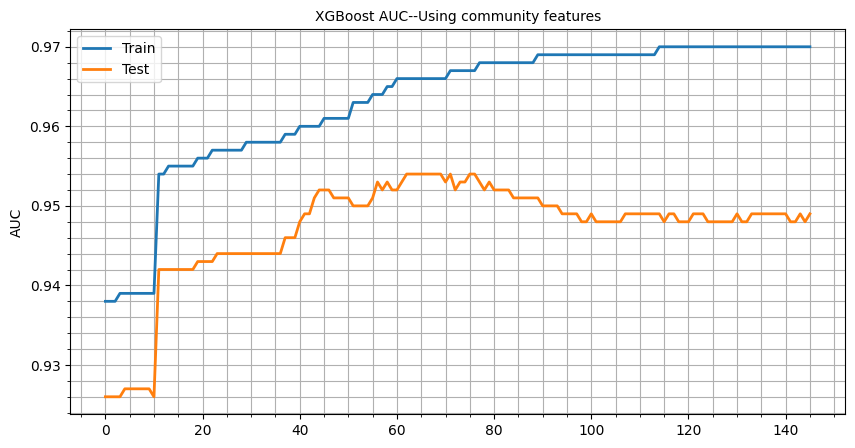

In [84]:
# 19.3 Modeling with Community data:

# Ref: https://stackoverflow.com/a/60366515
plt.figure(figsize = (10,5));
results = model_trans_commu.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid(visible = True, which = 'both')
plt.minorticks_on()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Using community features", fontsize = 10);


## Community data merged with original data

In [85]:
# 20.0 Merge above emgineered features with original data:

m_train = pd.merge( left= orig_train.iloc[:, :-1], right = fg_tr[0], left_index =True, right_index = True )
m_test = pd.merge( left= orig_test.iloc[:, :-1], right = fg_te[0], left_index =True, right_index = True )
m_train.head(2)
m_test.head(2)

MIP   StdDevIP  ExKurtosisIP    SkewIP  MeanDMSNR  StdDevDMSNR  \
279    78.460938  37.632246      0.761066  2.516426   2.241639    17.166000   
9802  137.500000  37.165172      0.224732  1.245371   3.239130    25.127128   

      ExKurtosisDMSNR  SkewDMSNR  MIP_projected_ExKurtosisIP.gml  \
279          8.768599  85.693532                               0   
9802         8.179860  68.019792                               1   

      MIP_projected_SkewIP.gml  ...  \
279                          1  ...   
9802                         0  ...   

      StdDevDMSNR_projected_ExKurtosisDMSNR.gml  \
279                                           1   
9802                                          1   

      ExKurtosisDMSNR_projected_MIP.gml  \
279                                   0   
9802                                  0   

      ExKurtosisDMSNR_projected_ExKurtosisIP.gml  \
279                                            0   
9802                                           0   

      ExKurtosisDMSNR_projected_MeanDMSNR.gml  \
279                                         0   
9802                                        0   

      ExKurtosisDMSNR_projected_StdDevDMSNR.gml  \
279                                           1   
9802                                          1   

      ExKurtosisDMSNR_projected_SkewDMSNR.gml  SkewDMSNR_projected_MIP.gml  \
279                                         0                            0   
9802                                        0                            1   

      SkewDMSNR_projected_StdDevIP.gml  SkewDMSNR_projected_StdDevDMSNR.gml  \
279                                  0                                    0   
9802                                 0                                    0   

      SkewDMSNR_projected_ExKurtosisDMSNR.gml  
279                                         1  
9802                                        1  

[2 rows x 32 columns]

MIP   StdDevIP  ExKurtosisIP    SkewIP  MeanDMSNR  StdDevDMSNR  \
437    121.15625  48.372971      0.375485 -0.013165   3.168896    18.399367   
10455   76.96875  36.175557      0.712898  3.388719   2.399666    17.570997   

       ExKurtosisDMSNR   SkewDMSNR  MIP_projected_ExKurtosisIP.gml  \
437           7.449874   65.159298                               0   
10455         9.414652  102.722975                               0   

       MIP_projected_SkewIP.gml  ...  \
437                           0  ...   
10455                         1  ...   

       StdDevDMSNR_projected_ExKurtosisDMSNR.gml  \
437                                            1   
10455                                          1   

       ExKurtosisDMSNR_projected_MIP.gml  \
437                                    1   
10455                                  0   

       ExKurtosisDMSNR_projected_ExKurtosisIP.gml  \
437                                             0   
10455                                           0   

       ExKurtosisDMSNR_projected_MeanDMSNR.gml  \
437                                          0   
10455                                        0   

       ExKurtosisDMSNR_projected_StdDevDMSNR.gml  \
437                                            1   
10455                                          1   

       ExKurtosisDMSNR_projected_SkewDMSNR.gml  SkewDMSNR_projected_MIP.gml  \
437                                          0                          1.0   
10455                                        0                          0.0   

       SkewDMSNR_projected_StdDevIP.gml  SkewDMSNR_projected_StdDevDMSNR.gml  \
437                                 0.0                                  0.0   
10455                               0.0                                  0.0   

       SkewDMSNR_projected_ExKurtosisDMSNR.gml  
437                                        1.0  
10455                                      1.0  

[2 rows x 32 columns]

In [86]:
# 20.1
m_train.shape  # (11276, 32)
m_test.shape   # (1252, 32)

(11276, 32)

(1252, 32)

In [87]:
# 20.2 Modeling with merged train/test data :

# Lest we repeat the process many times:
# Del the earlier result:

if 'model_orig_fe' in globals():
    del model_orig_fe

model_orig_fe = xgb.XGBClassifier(  n_estimators= 300,
                                        verbosity = 3,
                                        eta = 0.1,
                                        max_depth = 7,
                                        subsample = 0.8,
                                        random_state = rng,
                                      )


tr_X =   m_train
test_X = m_test
ytr = ytr
yte = yte


model_orig_fe.fit(tr_X, ytr.values,
                      early_stopping_rounds = 80,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[14:07:50] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[14:07:50] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation_0-auc:0.96573	validation_1-auc:0.96475
[14:07:50] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation_0-auc:0.97047	validation_1-auc:0.96349
[14:07:50] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=7
[2]	validation_0-auc:0.97149	validation_1-auc:0.95972
[14:07:51] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=7
[3]	validation_0-auc:0.97096	validation_1-auc:0.95957
[14:07:51] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=7
[4]	validation_0-auc:0.97511	validation_1-auc:0.95894
[14:07:51] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_d

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [88]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig_fe.best_score}"  # 0.975222133
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig_fe.best_iteration}"  # 216

'Best auc from orig train/test data: 0.9760207726327788'

'Best iteration from orig train/test data: 45'

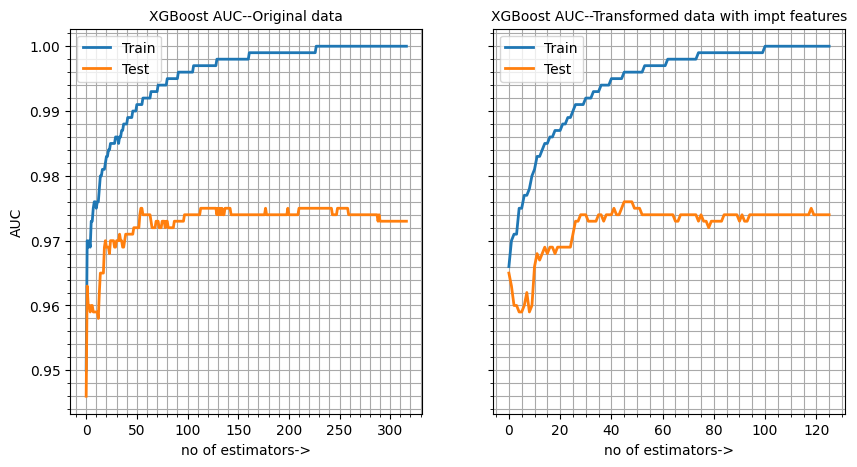

In [89]:
# 9.2 Learning curve-- original data:

# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey= True);

results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
ax[0].legend();
ax[0].grid(visible = True, which = 'both', color = "darkgrey")
ax[0].minorticks_on()
ax[0].set_ylabel('AUC');
ax[0].set_xlabel('no of estimators->')
ax[0].set_title("XGBoost AUC--Original data", fontsize = 10)

# 7.5 Learning curver-- transformed data:

results = model_orig_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],3), linewidth=2, label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth = 2, label='Test');
ax[1].legend();
ax[1].set_xlabel('no of estimators->')
ax[1].grid(visible = True, which = 'both', color = "darkgrey")
ax[1].minorticks_on()
ax[1].set_title('XGBoost AUC--Transformed data with impt features', fontsize = 10);
plt.show();

### PCA using community indicators:

In [90]:
# 20.0 Impute train data:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy = "most_frequent")
fg_tr[0][:] = si.fit_transform(fg_tr[0])
fg_tr[0].head(3)

MIP_projected_ExKurtosisIP.gml  MIP_projected_SkewIP.gml  \
279                                0                         1   
9802                               1                         0   
8792                               0                         0   

      StdDevIP_projected_MIP.gml  StdDevIP_projected_SkewIP.gml  \
279                            0                              1   
9802                           0                              1   
8792                           0                              1   

      StdDevIP_projected_MeanDMSNR.gml  ExKurtosisIP_projected_MIP.gml  \
279                                  0                               1   
9802                                 0                               1   
8792                                 1                               1   

      ExKurtosisIP_projected_StdDevIP.gml  ExKurtosisIP_projected_SkewIP.gml  \
279                                     1                                  1   
9802                                    0                                  0   
8792                                    1                                  1   

      SkewIP_projected_MIP.gml  SkewIP_projected_StdDevIP.gml  ...  \
279                          1                              0  ...   
9802                         1                              0  ...   
8792                         1                              0  ...   

      StdDevDMSNR_projected_ExKurtosisDMSNR.gml  \
279                                           1   
9802                                          1   
8792                                          0   

      ExKurtosisDMSNR_projected_MIP.gml  \
279                                   0   
9802                                  0   
8792                                  1   

      ExKurtosisDMSNR_projected_ExKurtosisIP.gml  \
279                                            0   
9802                                           0   
8792                                           1   

      ExKurtosisDMSNR_projected_MeanDMSNR.gml  \
279                                         0   
9802                                        0   
8792                                        1   

      ExKurtosisDMSNR_projected_StdDevDMSNR.gml  \
279                                           1   
9802                                          1   
8792                                          1   

      ExKurtosisDMSNR_projected_SkewDMSNR.gml  SkewDMSNR_projected_MIP.gml  \
279                                         0                            0   
9802                                        0                            1   
8792                                        0                            0   

      SkewDMSNR_projected_StdDevIP.gml  SkewDMSNR_projected_StdDevDMSNR.gml  \
279                                  0                                    0   
9802                                 0                                    0   
8792                                 0                                    0   

      SkewDMSNR_projected_ExKurtosisDMSNR.gml  
279                                         1  
9802                                        1  
8792                                        1  

[3 rows x 24 columns]

In [91]:
# 20.1 PCA next:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
commu_pca = pca.fit_transform(ss.fit_transform(fg_tr[0]))

# 20.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(commu_pca.shape[1])]
commu_pca = pd.DataFrame(commu_pca, columns = colnames)

In [92]:
# https://stackoverflow.com/a/64554001/3282777
# Generate jitter around values by center+random_frac, center-random frac

def jitter(values,center):
    return values + np.random.normal(center,0.2,values.shape)

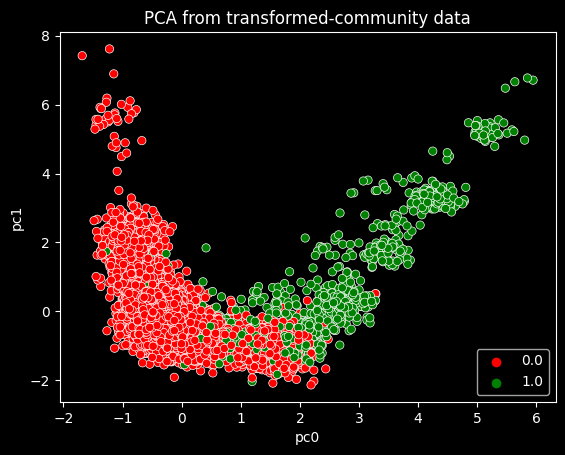

In [93]:
# 20.3 PCA plot of transformed data:
#      We add some jitter to display
#      overlapping points

plt.style.use("dark_background")
sns.scatterplot(data = commu_pca,
                x=  jitter(commu_pca.pc0, 0),
                y = jitter(commu_pca.pc1, 0),
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed-community data') ;

In [94]:
############## Done ##################

## Derive unit-vectors per level per cat column

In [95]:
##*****************************
## Embedding Projector
## Incidentally f1-score is highest
##*****************************

### REad data

In [96]:
# 21.1.1
test_binned = pd.read_pickle(Path(dataPath) / "test_binned.pkl")
test_trans = pd.read_pickle(Path(dataPath) / "test_trans.pkl")

# 21.1.2
train_binned = pd.read_pickle(Path(dataPath) / "train_binned.pkl")
train_trans = pd.read_pickle(Path(dataPath) / "train_trans.pkl")

# 21.1.3
orig_test = pd.read_pickle(Path(dataPath) / "orig_test.pkl")
orig_train = pd.read_pickle(Path(dataPath) / "orig_train.pkl")


# 21.1.5
y_train = train_binned['target'].reset_index(drop=True)
y_test = test_binned['target'].reset_index(drop = True)

# 21.1.6
ct = utils.restorePythonObject("transformer.pkl", dataPath)

In [97]:
# 21.2 Check for nulls:
train_trans.isnull().sum().sum()  # 0
print("---")
test_trans.isnull().sum().sum()   # 116

0

---


116

In [98]:
# 21.3 Impute test_trans
si = SimpleImputer(strategy = 'median')
si.fit(train_trans)
test_trans[:] = si.transform(test_trans)
# Check
test_trans.isnull().sum().sum()

SimpleImputer(strategy='median')

0

In [99]:
'target' in list(train_trans.columns)
'target' in list(test_trans.columns)

False

False

In [100]:
# 21.4 Get target data col.
#      Needed for generation of meta-data file:

test_trans['target'] = y_test
train_trans['target'] =  y_train

In [101]:
# 22.0 Derive unit vectors:

p = Path(unitvecPath)
p.mkdir(parents=True, exist_ok=True)

vec_tr,_ = ct.vectorsToTSV(train_trans,
                           take_mean = False,
                           filepath = unitvecPath,   # Folder where csv files will be saved
                           saveVectorsToDisk = True
                           )

print("\n----test data---\n")

# 22.1 Unit vectors from test data. But not being saved to file:
vec_te,_ = ct.vectorsToTSV(test_trans,
                           take_mean = False,
                           filepath = unitvecPath,
                           impute = True,
                           saveVectorsToDisk = False
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for MIP
Checked for StdDevIP
Checked for ExKurtosisIP
Checked for SkewIP
Checked for MeanDMSNR
Checked for StdDevDMSNR
Checked for ExKurtosisDMSNR
Checked for SkewDMSNR
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: '/gdrive/MyDrive/Colab_data_files/pulsar/unitvecfolder/'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature

----test data---

Checking if vectors exist for all cat cols...
May take time...
Checked for MIP
Checked for StdDevIP
Checked for ExKurtosisIP
Checked for SkewIP
Checked for MeanDMSNR
Checked for StdDevDMSNR
Checked for ExKurtosisDMSNR
Checked for SkewDMSNR


## Save unit-vectors files to gdrive
Also save output dictionaries for later use

In [102]:
# 22.2 Save dict to gdrive:

utils.savePythonObject(vec_tr, "vec_tr.pkl", unitvecPath)
utils.savePythonObject(vec_te, "vec_te.pkl",unitvecPath)

Object saved to: /gdrive/MyDrive/Colab_data_files/pulsar/unitvecfolder/vec_tr.pkl
Object saved to: /gdrive/MyDrive/Colab_data_files/pulsar/unitvecfolder/vec_te.pkl


## Restore unit-vectors files from gdrive

In [103]:
# 22.3 Restore back:
vec_tr = utils.restorePythonObject( "vec_tr.pkl", unitvecPath)
vec_te = utils.restorePythonObject("vec_te.pkl",unitvecPath)

## Using unit vectors to transform train/test data

In [104]:
# 23.0 USe unit vectors to transform train/test data:

cctr,ccte, vtr,vte = utils.pcaAndConcat(vec_tr, vec_te, n_components = 4)


Performing PCA for MIP for train data
Performing PCA for MIP for test data
Performing PCA for StdDevIP for train data
Performing PCA for StdDevIP for test data
Performing PCA for ExKurtosisIP for train data
Performing PCA for ExKurtosisIP for test data
Performing PCA for SkewIP for train data
Performing PCA for SkewIP for test data
Performing PCA for MeanDMSNR for train data
Performing PCA for MeanDMSNR for test data
Performing PCA for StdDevDMSNR for train data
Performing PCA for StdDevDMSNR for test data
Performing PCA for ExKurtosisDMSNR for train data
Performing PCA for ExKurtosisDMSNR for test data
Performing PCA for SkewDMSNR for train data
Performing PCA for SkewDMSNR for test data
Concatenating train data
Concatenating test data
Done......


In [105]:
# 23.1

cctr.head(3)
ccte.head(3)

pcMIP0    pcMIP1    pcMIP2    pcMIP3  pcStdDevIP0  pcStdDevIP1  \
0 -0.203184  9.383284 -1.478307 -0.441403    13.742193    -6.630572   
1 -0.856762 -3.586879  2.813205 -4.322406    13.742130    -6.630553   
2 -2.307311 -0.677137 -1.341751  0.455008    -2.903570     0.277947   

   pcStdDevIP2  pcStdDevIP3  pcExKurtosisIP0  pcExKurtosisIP1  ...  \
0     6.067469     1.118574         6.911747         0.612341  ...   
1     6.067538     1.118455        -9.665083        -0.021288  ...   
2    -1.712848     1.916182         5.192375         3.653478  ...   

   pcStdDevDMSNR2  pcStdDevDMSNR3  pcExKurtosisDMSNR0  pcExKurtosisDMSNR1  \
0       -0.789734       -0.232207            3.485134           -0.959522   
1        1.107142        2.221678            3.485212           -0.959701   
2        1.856680       -0.585208          -24.344748            0.073980   

   pcExKurtosisDMSNR2  pcExKurtosisDMSNR3  pcSkewDMSNR0  pcSkewDMSNR1  \
0           -0.309295            1.418212     -7.987277     -1.987364   
1           -0.309889            1.418446     -1.695392      9.285500   
2            0.029468           -2.253953     11.560293     -2.286284   

   pcSkewDMSNR2  pcSkewDMSNR3  
0     -0.052227      0.069949  
1     -1.830616      0.370626  
2     -0.544146      0.718606  

[3 rows x 32 columns]

pcMIP0    pcMIP1    pcMIP2    pcMIP3  pcStdDevIP0  pcStdDevIP1  \
0 -2.579238 -2.225889  0.624370  1.411841    -2.903590     0.277961   
1 -0.203193  9.383452 -1.478411 -0.441433    13.742144    -6.630606   
2 -1.649143 -2.924255  0.665285  1.403021    -2.426284    -1.224506   

   pcStdDevIP2  pcStdDevIP3  pcExKurtosisIP0  pcExKurtosisIP1  ...  \
0    -1.712841     1.916226         8.469187        -2.612574  ...   
1     6.067485     1.118556         6.911734         0.612351  ...   
2    -2.392625    -0.482455        -9.665090        -0.021232  ...   

   pcStdDevDMSNR2  pcStdDevDMSNR3  pcExKurtosisDMSNR0  pcExKurtosisDMSNR1  \
0       -2.657931       -0.900883            3.803069           -1.164673   
1       -0.789520       -0.231810            3.485191           -0.959686   
2       -0.834288        2.555522            3.485191           -0.959686   

   pcExKurtosisDMSNR2  pcExKurtosisDMSNR3  pcSkewDMSNR0  pcSkewDMSNR1  \
0            0.628729            0.276576     -1.695387      9.285512   
1           -0.309964            1.418538     -7.987200     -1.987767   
2           -0.309964            1.418538     -1.695387      9.285512   

   pcSkewDMSNR2  pcSkewDMSNR3  
0     -1.830567      0.370282  
1     -0.052089      0.070506  
2     -1.830567      0.370282  

[3 rows x 32 columns]

In [106]:
# 23.2

cctr.shape   #  (11276, 32)
ccte.shape   #  (1252, 32)

(11276, 32)

(1252, 32)

In [107]:
# 23.3

print(list(cctr.columns[:10]))
print(list(cctr.columns[10:20]))
print(list(cctr.columns[20:30]))
print(list(cctr.columns[30:40]))


['pcMIP0', 'pcMIP1', 'pcMIP2', 'pcMIP3', 'pcStdDevIP0', 'pcStdDevIP1', 'pcStdDevIP2', 'pcStdDevIP3', 'pcExKurtosisIP0', 'pcExKurtosisIP1']
['pcExKurtosisIP2', 'pcExKurtosisIP3', 'pcSkewIP0', 'pcSkewIP1', 'pcSkewIP2', 'pcSkewIP3', 'pcMeanDMSNR0', 'pcMeanDMSNR1', 'pcMeanDMSNR2', 'pcMeanDMSNR3']
['pcStdDevDMSNR0', 'pcStdDevDMSNR1', 'pcStdDevDMSNR2', 'pcStdDevDMSNR3', 'pcExKurtosisDMSNR0', 'pcExKurtosisDMSNR1', 'pcExKurtosisDMSNR2', 'pcExKurtosisDMSNR3', 'pcSkewDMSNR0', 'pcSkewDMSNR1']
['pcSkewDMSNR2', 'pcSkewDMSNR3']


### Save unitvectors transformed train/test

In [108]:
# 23.4 Save cctr/ccte to gdrive
cctr.to_pickle(Path(dataPath) / "cctr.pkl")
ccte.to_pickle(Path(dataPath) / "ccte.pkl")

### Readback unitvectors transformed train/test

In [109]:
# 24.0 Read back cctr/ccte
cctr = pd.read_pickle(Path(dataPath) / "cctr.pkl")
ccte = pd.read_pickle(Path(dataPath) / "ccte.pkl")

# Check
cctr.head(2)
ccte.head(2)
cctr.shape # (11276,32)
ccte.shape # (1252,32)

pcMIP0    pcMIP1    pcMIP2    pcMIP3  pcStdDevIP0  pcStdDevIP1  \
0 -0.203184  9.383284 -1.478307 -0.441403    13.742193    -6.630572   
1 -0.856762 -3.586879  2.813205 -4.322406    13.742130    -6.630553   

   pcStdDevIP2  pcStdDevIP3  pcExKurtosisIP0  pcExKurtosisIP1  ...  \
0     6.067469     1.118574         6.911747         0.612341  ...   
1     6.067538     1.118455        -9.665083        -0.021288  ...   

   pcStdDevDMSNR2  pcStdDevDMSNR3  pcExKurtosisDMSNR0  pcExKurtosisDMSNR1  \
0       -0.789734       -0.232207            3.485134           -0.959522   
1        1.107142        2.221678            3.485212           -0.959701   

   pcExKurtosisDMSNR2  pcExKurtosisDMSNR3  pcSkewDMSNR0  pcSkewDMSNR1  \
0           -0.309295            1.418212     -7.987277     -1.987364   
1           -0.309889            1.418446     -1.695392      9.285500   

   pcSkewDMSNR2  pcSkewDMSNR3  
0     -0.052227      0.069949  
1     -1.830616      0.370626  

[2 rows x 32 columns]

pcMIP0    pcMIP1    pcMIP2    pcMIP3  pcStdDevIP0  pcStdDevIP1  \
0 -2.579238 -2.225889  0.624370  1.411841    -2.903590     0.277961   
1 -0.203193  9.383452 -1.478411 -0.441433    13.742144    -6.630606   

   pcStdDevIP2  pcStdDevIP3  pcExKurtosisIP0  pcExKurtosisIP1  ...  \
0    -1.712841     1.916226         8.469187        -2.612574  ...   
1     6.067485     1.118556         6.911734         0.612351  ...   

   pcStdDevDMSNR2  pcStdDevDMSNR3  pcExKurtosisDMSNR0  pcExKurtosisDMSNR1  \
0       -2.657931       -0.900883            3.803069           -1.164673   
1       -0.789520       -0.231810            3.485191           -0.959686   

   pcExKurtosisDMSNR2  pcExKurtosisDMSNR3  pcSkewDMSNR0  pcSkewDMSNR1  \
0            0.628729            0.276576     -1.695387      9.285512   
1           -0.309964            1.418538     -7.987200     -1.987767   

   pcSkewDMSNR2  pcSkewDMSNR3  
0     -1.830567      0.370282  
1     -0.052089      0.070506  

[2 rows x 32 columns]

(11276, 32)

(1252, 32)

## xgboost modeling

In [110]:
# 24.1 Perform xgboost modeling using the above train/test data:

model_vec = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = None,
                              reg_lambda = 1.5,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    cctr
test_X =  ccte
ytrain =  y_train
ytest = y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[14:08:25] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[14:08:25] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation_0-auc:0.93721	validation_1-auc:0.91939
[14:08:25] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=9
[1]	validation_0-auc:0.93935	validation_1-auc:0.91945
[14:08:25] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=9
[2]	validation_0-auc:0.93940	validation_1-auc:0.91956
[14:08:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.93948	validation_1-auc:0.91991
[14:08:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation_0-auc:0.95009	validation_1-auc:0.94848
[14:08:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, ma

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [111]:
# 24.2 Best scores:

model_vec.best_score   # 0.964683313668
print("\n")
model_vec.best_iteration  # 93


0.9680504386492973

64

In [112]:
# 24.3 Classification report:

pred_vec = model_vec.predict(test_X)
print(classification_report(ytest,pred_vec))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1143
         1.0       0.93      0.82      0.87       109

    accuracy                           0.98      1252
   macro avg       0.95      0.91      0.93      1252
weighted avg       0.98      0.98      0.98      1252



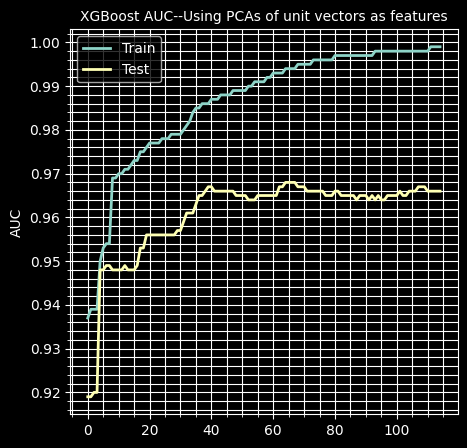

In [113]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_vec.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid(visible = True, which = 'both')
plt.minorticks_on()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize = 10);


## Feature Engineering with clustering

In [114]:
# 25.0 Create clustering features from unitvector dataframes:

n_components = 4  # No of components while performing PCA of every feature
fe_tr,fe_te = utils.featureEngKmeans(cctr,
                                     ccte,
                                     n_clusters = 4,  # No of clusters per feature
                                     step_size = n_components,
                                     km=True,  # Only perform KMeans
                                     gmm=False  # No Gaussian Mixture modeling
                                     )

Current index:  0
Current index:  4
Current index:  8
Current index:  12
Current index:  16
Current index:  20
Current index:  24
Current index:  28


In [115]:
# 25.1 Output is orig dataframe + clusters
fe_tr.head(3)
fe_te.head(3)

pcMIP0    pcMIP1    pcMIP2    pcMIP3  pcStdDevIP0  pcStdDevIP1  \
0 -0.203184  9.383284 -1.478307 -0.441403    13.742193    -6.630572   
1 -0.856762 -3.586879  2.813205 -4.322406    13.742130    -6.630553   
2 -2.307311 -0.677137 -1.341751  0.455008    -2.903570     0.277947   

   pcStdDevIP2  pcStdDevIP3  pcExKurtosisIP0  pcExKurtosisIP1  ...  \
0     6.067469     1.118574         6.911747         0.612341  ...   
1     6.067538     1.118455        -9.665083        -0.021288  ...   
2    -1.712848     1.916182         5.192375         3.653478  ...   

   pcSkewDMSNR2  pcSkewDMSNR3  clu0  clu1  clu2  clu3  clu4  clu5  clu6  clu7  
0     -0.052227      0.069949     2     2     2     0     1     2     0     1  
1     -1.830616      0.370626     0     2     1     0     1     3     0     2  
2     -0.544146      0.718606     0     1     2     0     2     0     1     0  

[3 rows x 40 columns]

pcMIP0    pcMIP1    pcMIP2    pcMIP3  pcStdDevIP0  pcStdDevIP1  \
0 -2.579238 -2.225889  0.624370  1.411841    -2.903590     0.277961   
1 -0.203193  9.383452 -1.478411 -0.441433    13.742144    -6.630606   
2 -1.649143 -2.924255  0.665285  1.403021    -2.426284    -1.224506   

   pcStdDevIP2  pcStdDevIP3  pcExKurtosisIP0  pcExKurtosisIP1  ...  \
0    -1.712841     1.916226         8.469187        -2.612574  ...   
1     6.067485     1.118556         6.911734         0.612351  ...   
2    -2.392625    -0.482455        -9.665090        -0.021232  ...   

   pcSkewDMSNR2  pcSkewDMSNR3  clu0  clu1  clu2  clu3  clu4  clu5  clu6  clu7  
0     -1.830567      0.370282     0     1     2     1     1     3     0     2  
1     -0.052089      0.070506     2     2     2     2     1     2     0     1  
2     -1.830567      0.370282     0     1     1     1     1     3     0     2  

[3 rows x 40 columns]

In [116]:
# 25.2 Have a look at clusters created:

fe_tr[fe_tr.columns[-len(cat_cols):]].head()
fe_te[fe_te.columns[-len(cat_cols):]].head()


clu0  clu1  clu2  clu3  clu4  clu5  clu6  clu7
0     2     2     2     0     1     2     0     1
1     0     2     1     0     1     3     0     2
2     0     1     2     0     2     0     1     0
3     0     3     1     1     1     3     0     2
4     0     2     2     0     1     1     0     1

clu0  clu1  clu2  clu3  clu4  clu5  clu6  clu7
0     0     1     2     1     1     3     0     2
1     2     2     2     2     1     2     0     1
2     0     1     1     1     1     3     0     2
3     0     1     3     1     0     2     1     0
4     2     2     2     2     1     3     0     2

In [117]:
# 25.3 Perform xgboost modeling using only the above clusters:

model_fe = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = None,
                              reg_lambda = 1.5,
                           )

tr_X =   fe_tr[fe_tr.columns[-len(cat_cols):]]
test_X =  fe_te[fe_te.columns[-len(cat_cols):]]
ytrain =  y_train
ytest = y_test


model_fe.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[14:08:37] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[14:08:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation_0-auc:0.93686	validation_1-auc:0.93787
[14:08:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation_0-auc:0.93803	validation_1-auc:0.94255
[14:08:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation_0-auc:0.95836	validation_1-auc:0.94645
[14:08:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.95824	validation_1-auc:0.94601
[14:08:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation_0-auc:0.95993	validation_1-auc:0.94664
[14:08:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, m

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [118]:
model_fe.best_score  # 0.96412145729


0.9608145312111216

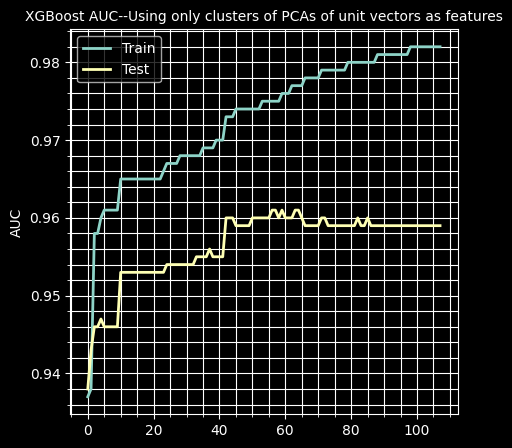

In [119]:
# 25.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid(visible = True, which = 'both')
plt.minorticks_on()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Using only clusters of PCAs of unit vectors as features", fontsize = 10);


## Averaged unit vectors per level per feature
Unit vectors can be used look at clusters of features in Embedding Projector

In [120]:
# 26.0
train_trans['target'] = y_train

vec_trx , _ = ct.vectorsToTSV(train_trans,
                           take_mean = True,
                           filepath = unitvecPath,   # Folder where csv files will be saved
                           saveVectorsToDisk = True,
                           fnamesuffix = "_avg"
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for MIP
Checked for StdDevIP
Checked for ExKurtosisIP
Checked for SkewIP
Checked for MeanDMSNR
Checked for StdDevDMSNR
Checked for ExKurtosisDMSNR
Checked for SkewDMSNR
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: '/gdrive/MyDrive/Colab_data_files/pulsar/unitvecfolder/'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


In [121]:
vec_trx['MIP'].shape  # (30, 116)

(30, 116)

A view of Embedding projector for textureMean. One can see around 4-clusters.